In [2]:
%pip uninstall -y transformers

Keyring is skipped due to an exception: 'keyring.backends'
Found existing installation: transformers 4.27.0.dev1
Uninstalling transformers-4.27.0.dev1:
  Successfully uninstalled transformers-4.27.0.dev1
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -r translation/requirements.txt
%pip install -e ~/transformers/ #Or wherever you downloaded this source  

  Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)
  Using cached datasets-2.12.0-py3-none-any.whl (474 kB)
  Using cached sentencepiece-0.1.99-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached sacrebleu-2.3.1-py3-none-any.whl (118 kB)
  Using cached py7zr-0.20.5-py3-none-any.whl (66 kB)
  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Using cached evaluate-0.4.0-py3-none-any.whl (81 kB)
  Using cached huggingface_hub-0.15.1-py3-none-any.whl (236 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
  Using cached xxhash-3.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (213 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached portalocker-2.7.0-py2.py3-none-any.whl (15 kB)
  Using cached pyppmd-1.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (138 kB)
  Using cached inflate64-0.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (93 kB)
  Using cached multivo

In [6]:
# Install SLS package
# pip install git+https://github.com/IssamLaradji/sls.git

In [2]:
import sys
import os
SRC_DIRS = [
    os.path.join('./', dirname) for dirname in [
        "text-generation",
        "text-classification",
        "token-classification",
        "language-modeling",
        "multiple-choice",
        "question-answering",
        "summarization",
        "translation",
        "image-classification",
        "speech-recognition",
        "audio-classification",
        "speech-pretraining",
        "image-pretraining",
        "semantic-segmentation",
    ]
]
sys.path.extend(SRC_DIRS)

# Comparing seeds 

In [3]:
from translation import run_translation
import argparse
import json
import logging
import os
import sys
from unittest.mock import patch

import torch

from transformers import ViTMAEForPreTraining, Wav2Vec2ForPreTraining
from transformers.testing_utils import CaptureLogger, TestCasePlus, get_gpu_count, slow, torch_device
from transformers.utils import is_apex_available
from utils import *

def get_results(output_dir):
    results = {}
    path = os.path.join(output_dir, "all_results.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            results = json.load(f)
    else:
        raise ValueError(f"can't find {path}")
    return results

In [4]:
import run_qa as run_squad
import argparse
import json
import logging
import os
import sys
from unittest.mock import patch

import torch

from transformers import ViTMAEForPreTraining, Wav2Vec2ForPreTraining
from transformers.testing_utils import CaptureLogger, TestCasePlus, get_gpu_count, slow, torch_device
from transformers.utils import is_apex_available
from utils import *


In [5]:
def run_translation_func(lr, seed):
    tmp_dir = get_auto_remove_tmp_dir()
    # testargs = f"""
    #     run_translation.py
    #     --model_name_or_path google/long-t5-tglobal-base
    #     --source_lang en
    #     --target_lang fr
    #     --dataset_name news_commentary
    #     --dataset_config_name en-fr
    #     --output_dir {tmp_dir}
    #     --overwrite_output_dir
    #     --max_steps=1000
    #     --warmup_steps=0
    #     --do_train
    #     --learning_rate={lr}
    #     --per_device_train_batch_size=4
    #     --per_device_eval_batch_size=4
    #     --predict_with_generate
    #     --save_strategy no
    #     --logging_steps 10
    #     --lr_scheduler_type constant
    #     --seed {seed}
    # """.split()
    
    
    # with patch.object(sys, "argv", testargs):
    #     run_translation.main()
    #     result = get_results(tmp_dir)
        # print(result["eval_bleu"]>30)
    
    # Changing to QnA here
    testargs = f"""
        run_qa.py
        --model_name_or_path xlm-roberta-base
        --dataset_name squad
        --output_dir {tmp_dir}
        --overwrite_output_dir
        --max_steps=1000
        --do_train
        --learning_rate={lr}
        --per_device_train_batch_size=2
        --per_device_eval_batch_size=1
        --save_strategy no
        --logging_steps 10
        --seed {seed}
        --optim sgd
        --lr_scheduler_type constant_with_warmup
        """.split()


        
    with patch.object(sys, "argv", testargs):
        run_squad.main()
        result = get_results(tmp_dir)
    
    return tmp_dir

Grid search Lr with same fixed seed - 42

In [6]:
lrs = [1e-6,1e-6,5e-5,5e-5,1e-5,1e-5,5e-4,5e-4,1e-4,1e-4, 5e-3,5e-3, 1e-3,1e-3]

In [7]:
result_dirs_42 = []
for lr in lrs:
    result_dirs_42.append(run_translation_func(lr, 42))

06/13/2023 22:11:29 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:11:29 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:11:31,241 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:11:31,287 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

Running tokenizer on train dataset:   0%|          | 0/87599 [00:00<?, ? examples/s]

06/13/2023 22:11:38 - INFO - datasets.arrow_dataset - Caching processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:12:09,720 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:12:09,726 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:12:09,727 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:12:09,727 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:12:09,728 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:12:09,728 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:12:09,729 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:12:09,730 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:12:09,731 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.020200
20,5.986100
30,6.035100
40,6.077000
50,6.018400
60,6.063000
70,6.121600
80,6.039400
90,6.066900
100,6.042000


[INFO|trainer.py:2032] 2023-06-13 22:13:20,635 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:13:20,637 >> Saving model checkpoint to /tmp/tmpq23icvpo
[INFO|configuration_utils.py:457] 2023-06-13 22:13:20,639 >> Configuration saved in /tmp/tmpq23icvpo/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:13:21,585 >> Model weights saved in /tmp/tmpq23icvpo/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:13:21,587 >> tokenizer config file saved in /tmp/tmpq23icvpo/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:13:21,588 >> Special tokens file saved in /tmp/tmpq23icvpo/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:13:22,079 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0402
  train_runtime            = 0:01:10.90
  train_samples            =      89597
  train_samples_per_second =     28.208
  train_steps_per_second   =     14.104


[INFO|training_args.py:1511] 2023-06-13 22:13:22,270 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:13:22,271 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:13:22 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:13:22 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:13:22,582 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:13:22,583 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:13:25 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:13:25,679 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:13:25,685 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:13:25,685 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:13:25,686 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:13:25,686 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:13:25,686 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:13:25,687 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:13:25,687 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:13:25,689 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.020200
20,5.986100
30,6.035100
40,6.077000
50,6.018400
60,6.063000
70,6.121600
80,6.039400
90,6.066900
100,6.042000


[INFO|trainer.py:2032] 2023-06-13 22:14:36,092 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:14:36,095 >> Saving model checkpoint to /tmp/tmpmvetd_36
[INFO|configuration_utils.py:457] 2023-06-13 22:14:36,096 >> Configuration saved in /tmp/tmpmvetd_36/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:14:37,053 >> Model weights saved in /tmp/tmpmvetd_36/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:14:37,055 >> tokenizer config file saved in /tmp/tmpmvetd_36/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:14:37,055 >> Special tokens file saved in /tmp/tmpmvetd_36/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:14:37,476 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0402
  train_runtime            = 0:01:10.40
  train_samples            =      89597
  train_samples_per_second =     28.408
  train_steps_per_second   =     14.204


[INFO|training_args.py:1511] 2023-06-13 22:14:37,663 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:14:37,663 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:14:37 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:14:37 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:14:38,217 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:14:38,218 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:14:40 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:14:41,059 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:14:41,066 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:14:41,066 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:14:41,067 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:14:41,067 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:14:41,068 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:14:41,068 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:14:41,069 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:14:41,070 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.019800
20,5.984800
30,6.032800
40,6.073200
50,6.014400
60,6.057600
70,6.115000
80,6.031200
90,6.057100
100,6.033000


[INFO|trainer.py:2032] 2023-06-13 22:15:51,544 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:15:51,547 >> Saving model checkpoint to /tmp/tmpl3gcos3g
[INFO|configuration_utils.py:457] 2023-06-13 22:15:51,549 >> Configuration saved in /tmp/tmpl3gcos3g/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:15:52,497 >> Model weights saved in /tmp/tmpl3gcos3g/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:15:52,499 >> tokenizer config file saved in /tmp/tmpl3gcos3g/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:15:52,500 >> Special tokens file saved in /tmp/tmpl3gcos3g/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:15:52,913 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9989
  train_runtime            = 0:01:10.47
  train_samples            =      89597
  train_samples_per_second =     28.379
  train_steps_per_second   =      14.19


[INFO|training_args.py:1511] 2023-06-13 22:15:53,098 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:15:53,098 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:15:53 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:15:53 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:15:53,519 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:15:53,521 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:15:56 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:15:56,350 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:15:56,356 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:15:56,357 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:15:56,357 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:15:56,358 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:15:56,358 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:15:56,359 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:15:56,359 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:15:56,360 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.019800
20,5.984800
30,6.032800
40,6.073200
50,6.014400
60,6.057600
70,6.115000
80,6.031200
90,6.057100
100,6.033000


[INFO|trainer.py:2032] 2023-06-13 22:17:06,893 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:17:06,895 >> Saving model checkpoint to /tmp/tmprfijnzlt
[INFO|configuration_utils.py:457] 2023-06-13 22:17:06,897 >> Configuration saved in /tmp/tmprfijnzlt/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:17:07,848 >> Model weights saved in /tmp/tmprfijnzlt/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:17:07,850 >> tokenizer config file saved in /tmp/tmprfijnzlt/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:17:07,850 >> Special tokens file saved in /tmp/tmprfijnzlt/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:17:08,354 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9989
  train_runtime            = 0:01:10.53
  train_samples            =      89597
  train_samples_per_second =     28.356
  train_steps_per_second   =     14.178


[INFO|training_args.py:1511] 2023-06-13 22:17:08,535 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:17:08,536 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:17:08 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:17:08 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:17:08,995 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:17:08,996 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:17:11 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:17:11,931 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:17:11,938 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:17:11,938 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:17:11,939 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:17:11,939 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:17:11,940 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:17:11,940 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:17:11,941 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:17:11,942 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.020100
20,5.985800
30,6.034700
40,6.076300
50,6.017700
60,6.062100
70,6.120400
80,6.037900
90,6.065200
100,6.040200


[INFO|trainer.py:2032] 2023-06-13 22:18:22,377 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:18:22,379 >> Saving model checkpoint to /tmp/tmp2idrtpdh
[INFO|configuration_utils.py:457] 2023-06-13 22:18:22,381 >> Configuration saved in /tmp/tmp2idrtpdh/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:18:23,347 >> Model weights saved in /tmp/tmp2idrtpdh/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:18:23,349 >> tokenizer config file saved in /tmp/tmp2idrtpdh/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:18:23,350 >> Special tokens file saved in /tmp/tmp2idrtpdh/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0314
  train_runtime            = 0:01:10.43
  train_samples            =      89597
  train_samples_per_second =     28.395
  train_steps_per_second   =     14.197


[INFO|modelcard.py:449] 2023-06-13 22:19:02,855 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:19:03,037 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:19:03,038 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:19:03 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:19:03 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:19:28,633 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:19:28,635 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:19:31 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:19:32,052 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:19:32,058 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:19:32,058 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:19:32,059 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:19:32,059 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:19:32,060 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:19:32,060 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:19:32,061 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:19:32,062 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.020100
20,5.985800
30,6.034700
40,6.076300
50,6.017700
60,6.062100
70,6.120400
80,6.037900
90,6.065200
100,6.040200


[INFO|trainer.py:2032] 2023-06-13 22:20:42,479 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:20:42,482 >> Saving model checkpoint to /tmp/tmpj1tksyso
[INFO|configuration_utils.py:457] 2023-06-13 22:20:42,483 >> Configuration saved in /tmp/tmpj1tksyso/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:20:43,438 >> Model weights saved in /tmp/tmpj1tksyso/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:20:43,439 >> tokenizer config file saved in /tmp/tmpj1tksyso/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:20:43,440 >> Special tokens file saved in /tmp/tmpj1tksyso/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:20:43,923 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0314
  train_runtime            = 0:01:10.41
  train_samples            =      89597
  train_samples_per_second =     28.402
  train_steps_per_second   =     14.201


[INFO|training_args.py:1511] 2023-06-13 22:20:44,107 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:20:44,107 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:20:44 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:20:44 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:20:44,467 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:20:44,468 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:20:47 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:20:47,389 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:20:47,395 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:20:47,396 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:20:47,396 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:20:47,397 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:20:47,398 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:20:47,398 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:20:47,399 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:20:47,400 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.015200
20,5.974100
30,6.013700
40,6.045500
50,5.983900
60,6.016400
70,6.065000
80,5.977000
90,5.985000
100,5.967100


[INFO|trainer.py:2032] 2023-06-13 22:21:57,918 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:21:57,920 >> Saving model checkpoint to /tmp/tmpf6wl6u6m
[INFO|configuration_utils.py:457] 2023-06-13 22:21:57,922 >> Configuration saved in /tmp/tmpf6wl6u6m/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:21:58,880 >> Model weights saved in /tmp/tmpf6wl6u6m/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:21:58,882 >> tokenizer config file saved in /tmp/tmpf6wl6u6m/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:21:58,882 >> Special tokens file saved in /tmp/tmpf6wl6u6m/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:21:59,324 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.5472
  train_runtime            = 0:01:10.51
  train_samples            =      89597
  train_samples_per_second =     28.362
  train_steps_per_second   =     14.181


[INFO|training_args.py:1511] 2023-06-13 22:21:59,505 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:21:59,506 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:21:59 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:21:59 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:21:59,814 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:21:59,816 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:22:02 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:22:02,660 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:22:02,666 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:22:02,667 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:22:02,667 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:22:02,668 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:22:02,668 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:22:02,669 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:22:02,670 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:22:02,671 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.015200
20,5.974100
30,6.013700
40,6.045500
50,5.983900
60,6.016400
70,6.065000
80,5.977000
90,5.985000
100,5.967100


[INFO|trainer.py:2032] 2023-06-13 22:23:13,248 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:23:13,250 >> Saving model checkpoint to /tmp/tmpewzkus3x
[INFO|configuration_utils.py:457] 2023-06-13 22:23:13,252 >> Configuration saved in /tmp/tmpewzkus3x/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:23:14,208 >> Model weights saved in /tmp/tmpewzkus3x/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:23:14,209 >> tokenizer config file saved in /tmp/tmpewzkus3x/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:23:14,210 >> Special tokens file saved in /tmp/tmpewzkus3x/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:23:14,741 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.5472
  train_runtime            = 0:01:10.57
  train_samples            =      89597
  train_samples_per_second =     28.338
  train_steps_per_second   =     14.169


[INFO|training_args.py:1511] 2023-06-13 22:23:14,928 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:23:14,928 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:23:14 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:23:14 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:23:15,246 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:23:15,247 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:23:17 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:23:18,164 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:23:18,171 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:23:18,171 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:23:18,172 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:23:18,173 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:23:18,174 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:23:18,174 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:23:18,175 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:23:18,179 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.019300
20,5.983500
30,6.030800
40,6.069700
50,6.010400
60,6.052300
70,6.108500
80,6.024100
90,6.047500
100,6.024000


[INFO|trainer.py:2032] 2023-06-13 22:24:28,725 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:24:28,728 >> Saving model checkpoint to /tmp/tmpf_2_684l
[INFO|configuration_utils.py:457] 2023-06-13 22:24:28,729 >> Configuration saved in /tmp/tmpf_2_684l/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:24:29,694 >> Model weights saved in /tmp/tmpf_2_684l/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:24:29,695 >> tokenizer config file saved in /tmp/tmpf_2_684l/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:24:29,696 >> Special tokens file saved in /tmp/tmpf_2_684l/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9587
  train_runtime            = 0:01:10.54
  train_samples            =      89597
  train_samples_per_second =      28.35
  train_steps_per_second   =     14.175


[INFO|modelcard.py:449] 2023-06-13 22:24:30,288 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:24:30,472 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:24:30,472 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:24:30 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:24:30 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:24:30,773 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:24:30,774 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:24:33 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:24:33,617 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:24:33,623 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:24:33,623 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:24:33,624 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:24:33,625 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:24:33,625 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:24:33,626 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:24:33,626 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:24:33,627 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.019300
20,5.983500
30,6.030800
40,6.069700
50,6.010400
60,6.052300
70,6.108500
80,6.024100
90,6.047500
100,6.024000


[INFO|trainer.py:2032] 2023-06-13 22:25:44,131 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:25:44,133 >> Saving model checkpoint to /tmp/tmpqs0nquya
[INFO|configuration_utils.py:457] 2023-06-13 22:25:44,135 >> Configuration saved in /tmp/tmpqs0nquya/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:25:45,095 >> Model weights saved in /tmp/tmpqs0nquya/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:25:45,096 >> tokenizer config file saved in /tmp/tmpqs0nquya/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:25:45,097 >> Special tokens file saved in /tmp/tmpqs0nquya/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:25:45,550 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9587
  train_runtime            = 0:01:10.50
  train_samples            =      89597
  train_samples_per_second =     28.367
  train_steps_per_second   =     14.184


[INFO|training_args.py:1511] 2023-06-13 22:25:45,731 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:25:45,731 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:25:45 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:25:45 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:25:46,184 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:25:46,185 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:25:48 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:25:49,038 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:25:49,045 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:25:49,045 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:25:49,045 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:25:49,046 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:25:49,046 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:25:49,047 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:25:49,047 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:25:49,049 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,5.981100
20,5.919400
30,5.933300
40,5.953300
50,5.877300
60,5.880100
70,5.862200
80,5.766900
90,5.717700
100,5.668100


[INFO|trainer.py:2032] 2023-06-13 22:26:59,599 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:26:59,601 >> Saving model checkpoint to /tmp/tmp6e62dmrd
[INFO|configuration_utils.py:457] 2023-06-13 22:26:59,603 >> Configuration saved in /tmp/tmp6e62dmrd/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:27:00,581 >> Model weights saved in /tmp/tmp6e62dmrd/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:27:00,582 >> tokenizer config file saved in /tmp/tmp6e62dmrd/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:27:00,583 >> Special tokens file saved in /tmp/tmp6e62dmrd/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:27:01,079 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     4.7059
  train_runtime            = 0:01:10.54
  train_samples            =      89597
  train_samples_per_second =     28.349
  train_steps_per_second   =     14.174


[INFO|training_args.py:1511] 2023-06-13 22:27:01,263 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:27:01,264 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:27:01 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:27:01 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:27:01,792 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:27:01,793 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:27:04 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:27:04,635 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:27:04,641 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:27:04,642 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:27:04,643 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:27:04,643 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:27:04,644 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:27:04,645 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:27:04,645 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:27:04,646 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,5.981100
20,5.919400
30,5.933300
40,5.953300
50,5.877300
60,5.880100
70,5.862200
80,5.766900
90,5.717700
100,5.668100


[INFO|trainer.py:2032] 2023-06-13 22:28:15,129 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:28:15,131 >> Saving model checkpoint to /tmp/tmp97qh7gm4
[INFO|configuration_utils.py:457] 2023-06-13 22:28:15,134 >> Configuration saved in /tmp/tmp97qh7gm4/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:28:16,084 >> Model weights saved in /tmp/tmp97qh7gm4/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:28:16,085 >> tokenizer config file saved in /tmp/tmp97qh7gm4/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:28:16,086 >> Special tokens file saved in /tmp/tmp97qh7gm4/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:28:16,562 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     4.7059
  train_runtime            = 0:01:10.48
  train_samples            =      89597
  train_samples_per_second =     28.376
  train_steps_per_second   =     14.188


[INFO|training_args.py:1511] 2023-06-13 22:28:16,747 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:28:16,748 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:28:16 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:28:16 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:28:17,137 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:28:17,138 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:28:19 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:28:20,249 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:28:20,255 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:28:20,256 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:28:20,256 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:28:20,257 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:28:20,258 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:28:20,258 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:28:20,259 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:28:20,263 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.010500
20,5.962500
30,5.992300
40,6.016000
50,5.953300
60,5.976100
70,6.010100
80,5.910500
90,5.894500
100,5.838100


[INFO|trainer.py:2032] 2023-06-13 22:29:30,760 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:29:30,762 >> Saving model checkpoint to /tmp/tmprejorerc
[INFO|configuration_utils.py:457] 2023-06-13 22:29:30,764 >> Configuration saved in /tmp/tmprejorerc/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:29:31,718 >> Model weights saved in /tmp/tmprejorerc/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:29:31,720 >> tokenizer config file saved in /tmp/tmprejorerc/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:29:31,720 >> Special tokens file saved in /tmp/tmprejorerc/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:29:32,159 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.3686
  train_runtime            = 0:01:10.49
  train_samples            =      89597
  train_samples_per_second =      28.37
  train_steps_per_second   =     14.185


[INFO|training_args.py:1511] 2023-06-13 22:29:32,425 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:29:32,426 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:29:32 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:29:32 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:29:32,714 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:29:32,715 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:29:35 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:29:35,521 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:29:35,528 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:29:35,528 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:29:35,529 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:29:35,529 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:29:35,530 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:29:35,530 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:29:35,531 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:29:35,535 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.010500
20,5.962500
30,5.992300
40,6.016000
50,5.953300
60,5.976100
70,6.010100
80,5.910500
90,5.894500
100,5.838100


[INFO|trainer.py:2032] 2023-06-13 22:30:45,973 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:30:45,975 >> Saving model checkpoint to /tmp/tmpw82z_6g8
[INFO|configuration_utils.py:457] 2023-06-13 22:30:45,977 >> Configuration saved in /tmp/tmpw82z_6g8/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:30:46,931 >> Model weights saved in /tmp/tmpw82z_6g8/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:30:46,932 >> tokenizer config file saved in /tmp/tmpw82z_6g8/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:30:46,933 >> Special tokens file saved in /tmp/tmpw82z_6g8/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:30:47,377 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.3686
  train_runtime            = 0:01:10.43
  train_samples            =      89597
  train_samples_per_second =     28.394
  train_steps_per_second   =     14.197


In [8]:
result_dirs_20 = []
for lr in lrs:
    result_dirs_20.append(run_translation_func(lr, 20))

[INFO|training_args.py:1511] 2023-06-13 22:30:47,574 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:30:47,574 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:30:47 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:30:47 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:30:47,881 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:30:47,883 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:30:50 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:30:50,731 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:30:50,737 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:30:50,737 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:30:50,738 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:30:50,738 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:30:50,739 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:30:50,739 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:30:50,739 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:30:50,741 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.088300
20,5.950500
30,6.012000
40,6.020600
50,6.007800
60,6.045900
70,6.015600
80,5.950900
90,5.969900
100,6.049100


[INFO|trainer.py:2032] 2023-06-13 22:32:01,097 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:32:01,100 >> Saving model checkpoint to /tmp/tmp_94u0yoi
[INFO|configuration_utils.py:457] 2023-06-13 22:32:01,101 >> Configuration saved in /tmp/tmp_94u0yoi/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:32:02,058 >> Model weights saved in /tmp/tmp_94u0yoi/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:32:02,059 >> tokenizer config file saved in /tmp/tmp_94u0yoi/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:32:02,060 >> Special tokens file saved in /tmp/tmp_94u0yoi/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:32:02,488 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0171
  train_runtime            = 0:01:10.35
  train_samples            =      89597
  train_samples_per_second =     28.426
  train_steps_per_second   =     14.213


[INFO|training_args.py:1511] 2023-06-13 22:32:02,674 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:32:02,675 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:32:02 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:32:02 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:32:03,023 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:32:03,024 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:32:05 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:32:05,910 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:32:05,917 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:32:05,917 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:32:05,918 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:32:05,918 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:32:05,919 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:32:05,920 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:32:05,920 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:32:05,922 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.088300
20,5.950500
30,6.012000
40,6.020600
50,6.007800
60,6.045900
70,6.015600
80,5.950900
90,5.969900
100,6.049100


[INFO|trainer.py:2032] 2023-06-13 22:33:16,289 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:33:16,291 >> Saving model checkpoint to /tmp/tmpefj5vjdu
[INFO|configuration_utils.py:457] 2023-06-13 22:33:16,293 >> Configuration saved in /tmp/tmpefj5vjdu/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:33:17,251 >> Model weights saved in /tmp/tmpefj5vjdu/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:33:17,253 >> tokenizer config file saved in /tmp/tmpefj5vjdu/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:33:17,254 >> Special tokens file saved in /tmp/tmpefj5vjdu/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:33:17,716 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0171
  train_runtime            = 0:01:10.36
  train_samples            =      89597
  train_samples_per_second =     28.422
  train_steps_per_second   =     14.211


[INFO|training_args.py:1511] 2023-06-13 22:33:17,898 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:33:17,899 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:33:17 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:33:17 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:33:18,190 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:33:18,192 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:33:20 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:33:21,092 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:33:21,098 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:33:21,099 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:33:21,099 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:33:21,100 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:33:21,100 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:33:21,101 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:33:21,102 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:33:21,103 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.087600
20,5.949100
30,6.009500
40,6.016600
50,6.003200
60,6.039200
70,6.009100
80,5.946400
90,5.962200
100,6.038800


[INFO|trainer.py:2032] 2023-06-13 22:34:31,627 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:34:31,630 >> Saving model checkpoint to /tmp/tmpkx572imm
[INFO|configuration_utils.py:457] 2023-06-13 22:34:31,632 >> Configuration saved in /tmp/tmpkx572imm/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:34:32,579 >> Model weights saved in /tmp/tmpkx572imm/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:34:32,581 >> tokenizer config file saved in /tmp/tmpkx572imm/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:34:32,582 >> Special tokens file saved in /tmp/tmpkx572imm/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9732
  train_runtime            = 0:01:10.52
  train_samples            =      89597
  train_samples_per_second =     28.359
  train_steps_per_second   =     14.179


[INFO|modelcard.py:449] 2023-06-13 22:34:34,946 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:34:35,131 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:34:35,132 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:34:35 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:34:35 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:34:35,434 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:34:35,435 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:34:38 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:34:38,286 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:34:38,293 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:34:38,293 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:34:38,293 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:34:38,295 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:34:38,295 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:34:38,295 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:34:38,296 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:34:38,297 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.087600
20,5.949100
30,6.009500
40,6.016600
50,6.003200
60,6.039200
70,6.009100
80,5.946400
90,5.962200
100,6.038800


[INFO|trainer.py:2032] 2023-06-13 22:35:48,896 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:35:48,898 >> Saving model checkpoint to /tmp/tmpc90noket
[INFO|configuration_utils.py:457] 2023-06-13 22:35:48,900 >> Configuration saved in /tmp/tmpc90noket/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:35:49,861 >> Model weights saved in /tmp/tmpc90noket/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:35:49,862 >> tokenizer config file saved in /tmp/tmpc90noket/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:35:49,863 >> Special tokens file saved in /tmp/tmpc90noket/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:35:50,311 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9732
  train_runtime            = 0:01:10.59
  train_samples            =      89597
  train_samples_per_second =     28.329
  train_steps_per_second   =     14.164


[INFO|training_args.py:1511] 2023-06-13 22:35:50,501 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:35:50,502 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:35:50 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:35:50 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:35:50,803 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:35:50,804 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:35:53 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:35:53,688 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:35:53,694 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:35:53,695 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:35:53,695 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:35:53,696 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:35:53,697 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:35:53,697 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:35:53,698 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:35:53,699 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.088200
20,5.950200
30,6.011600
40,6.019800
50,6.007000
60,6.044700
70,6.014400
80,5.950000
90,5.968500
100,6.047300


[INFO|trainer.py:2032] 2023-06-13 22:37:04,144 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:37:04,147 >> Saving model checkpoint to /tmp/tmp7nivvg8z
[INFO|configuration_utils.py:457] 2023-06-13 22:37:04,148 >> Configuration saved in /tmp/tmp7nivvg8z/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:37:05,106 >> Model weights saved in /tmp/tmp7nivvg8z/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:37:05,108 >> tokenizer config file saved in /tmp/tmp7nivvg8z/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:37:05,109 >> Special tokens file saved in /tmp/tmp7nivvg8z/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:37:05,599 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0076
  train_runtime            = 0:01:10.44
  train_samples            =      89597
  train_samples_per_second =      28.39
  train_steps_per_second   =     14.195


[INFO|training_args.py:1511] 2023-06-13 22:37:05,789 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:37:05,790 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:37:05 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:37:05 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:37:06,109 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:37:06,110 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:37:08 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:37:09,033 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:37:09,040 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:37:09,040 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:37:09,041 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:37:09,041 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:37:09,041 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:37:09,042 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:37:09,042 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:37:09,043 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.088200
20,5.950200
30,6.011600
40,6.019800
50,6.007000
60,6.044700
70,6.014400
80,5.950000
90,5.968500
100,6.047300


[INFO|trainer.py:2032] 2023-06-13 22:38:19,584 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:38:19,586 >> Saving model checkpoint to /tmp/tmp6qjw5zq8
[INFO|configuration_utils.py:457] 2023-06-13 22:38:19,588 >> Configuration saved in /tmp/tmp6qjw5zq8/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:38:20,549 >> Model weights saved in /tmp/tmp6qjw5zq8/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:38:20,550 >> tokenizer config file saved in /tmp/tmp6qjw5zq8/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:38:20,551 >> Special tokens file saved in /tmp/tmp6qjw5zq8/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:38:21,009 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     6.0076
  train_runtime            = 0:01:10.54
  train_samples            =      89597
  train_samples_per_second =     28.352
  train_steps_per_second   =     14.176


[INFO|training_args.py:1511] 2023-06-13 22:38:21,192 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:38:21,193 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:38:21 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:38:21 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:38:21,674 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:38:21,676 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:38:24 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:38:24,651 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:38:24,657 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:38:24,657 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:38:24,658 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:38:24,658 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:38:24,659 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:38:24,659 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:38:24,660 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:38:24,661 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.081400
20,5.938200
30,5.988300
40,5.983600
50,5.964900
60,5.988000
70,5.960900
80,5.913900
90,5.910900
100,5.969100


[INFO|trainer.py:2032] 2023-06-13 22:39:34,951 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:39:34,954 >> Saving model checkpoint to /tmp/tmpo968528a
[INFO|configuration_utils.py:457] 2023-06-13 22:39:34,956 >> Configuration saved in /tmp/tmpo968528a/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:39:35,914 >> Model weights saved in /tmp/tmpo968528a/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:39:35,916 >> tokenizer config file saved in /tmp/tmpo968528a/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:39:35,917 >> Special tokens file saved in /tmp/tmpo968528a/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:39:36,381 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.5812
  train_runtime            = 0:01:10.29
  train_samples            =      89597
  train_samples_per_second =     28.453
  train_steps_per_second   =     14.227


[INFO|training_args.py:1511] 2023-06-13 22:39:36,569 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:39:36,570 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:39:36 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:39:36 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:39:37,026 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:39:37,027 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:39:39 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:39:39,895 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:39:39,901 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:39:39,902 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:39:39,902 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:39:39,903 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:39:39,903 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:39:39,904 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:39:39,905 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:39:39,906 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.081400
20,5.938200
30,5.988300
40,5.983600
50,5.964900
60,5.988000
70,5.960900
80,5.913900
90,5.910900
100,5.969100


[INFO|trainer.py:2032] 2023-06-13 22:40:50,500 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:40:50,502 >> Saving model checkpoint to /tmp/tmp2ixlkfbg
[INFO|configuration_utils.py:457] 2023-06-13 22:40:50,504 >> Configuration saved in /tmp/tmp2ixlkfbg/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:40:51,468 >> Model weights saved in /tmp/tmp2ixlkfbg/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:40:51,469 >> tokenizer config file saved in /tmp/tmp2ixlkfbg/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:40:51,470 >> Special tokens file saved in /tmp/tmp2ixlkfbg/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.5812
  train_runtime            = 0:01:10.59
  train_samples            =      89597
  train_samples_per_second =     28.331
  train_steps_per_second   =     14.165


[INFO|modelcard.py:449] 2023-06-13 22:40:56,553 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:40:56,736 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:40:56,737 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:40:56 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:40:56 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:40:57,120 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:40:57,121 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:40:59 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:41:00,155 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:41:00,161 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:41:00,161 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:41:00,162 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:41:00,162 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:41:00,163 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:41:00,163 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:41:00,165 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:41:00,166 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.086800
20,5.947700
30,6.007000
40,6.012600
50,5.998600
60,6.033100
70,6.002900
80,5.942100
90,5.955100
100,6.029000


[INFO|trainer.py:2032] 2023-06-13 22:42:10,692 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:42:10,694 >> Saving model checkpoint to /tmp/tmpp2_s25ez
[INFO|configuration_utils.py:457] 2023-06-13 22:42:10,696 >> Configuration saved in /tmp/tmpp2_s25ez/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:42:11,659 >> Model weights saved in /tmp/tmpp2_s25ez/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:42:11,661 >> tokenizer config file saved in /tmp/tmpp2_s25ez/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:42:11,661 >> Special tokens file saved in /tmp/tmpp2_s25ez/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9407
  train_runtime            = 0:01:10.52
  train_samples            =      89597
  train_samples_per_second =     28.358
  train_steps_per_second   =     14.179


[INFO|modelcard.py:449] 2023-06-13 22:42:13,198 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:42:13,387 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:42:13,388 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:42:13 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:42:13 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:42:13,773 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:42:13,774 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:42:16 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:42:16,985 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:42:16,991 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:42:16,992 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:42:16,992 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:42:16,993 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:42:16,993 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:42:16,994 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:42:16,994 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:42:16,995 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.086800
20,5.947700
30,6.007000
40,6.012600
50,5.998600
60,6.033100
70,6.002900
80,5.942100
90,5.955100
100,6.029000


[INFO|trainer.py:2032] 2023-06-13 22:43:27,447 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:43:27,449 >> Saving model checkpoint to /tmp/tmpe68gmyhh
[INFO|configuration_utils.py:457] 2023-06-13 22:43:27,451 >> Configuration saved in /tmp/tmpe68gmyhh/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:43:28,410 >> Model weights saved in /tmp/tmpe68gmyhh/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:43:28,411 >> tokenizer config file saved in /tmp/tmpe68gmyhh/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:43:28,412 >> Special tokens file saved in /tmp/tmpe68gmyhh/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.9407
  train_runtime            = 0:01:10.45
  train_samples            =      89597
  train_samples_per_second =     28.389
  train_steps_per_second   =     14.194


[INFO|modelcard.py:449] 2023-06-13 22:43:29,006 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:43:29,186 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:43:29,186 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:43:29 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:43:29 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:43:29,712 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:43:29,713 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:43:32 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:43:32,807 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:43:32,814 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:43:32,814 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:43:32,815 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:43:32,816 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:43:32,817 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:43:32,817 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:43:32,817 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:43:32,819 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.031200
20,5.875900
30,5.883700
40,5.851700
50,5.803100
60,5.820700
70,5.733200
80,5.732300
90,5.669300
100,5.635500


[INFO|trainer.py:2032] 2023-06-13 22:44:43,221 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:44:43,223 >> Saving model checkpoint to /tmp/tmpuje1wfrh
[INFO|configuration_utils.py:457] 2023-06-13 22:44:43,225 >> Configuration saved in /tmp/tmpuje1wfrh/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:44:44,174 >> Model weights saved in /tmp/tmpuje1wfrh/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:44:44,175 >> tokenizer config file saved in /tmp/tmpuje1wfrh/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:44:44,176 >> Special tokens file saved in /tmp/tmpuje1wfrh/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     4.7321
  train_runtime            = 0:01:10.40
  train_samples            =      89597
  train_samples_per_second =     28.408
  train_steps_per_second   =     14.204


[INFO|modelcard.py:449] 2023-06-13 22:45:19,171 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:45:19,354 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:45:19,355 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:45:19 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:45:19 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:45:47,125 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:45:47,126 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:46:03 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:46:06,759 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:46:06,766 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:46:06,766 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:46:06,767 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:46:06,767 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:46:06,768 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:46:06,768 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:46:06,769 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:46:06,770 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.031200
20,5.875900
30,5.883700
40,5.851700
50,5.803100
60,5.820700
70,5.733200
80,5.732300
90,5.669300
100,5.635500


[INFO|trainer.py:2032] 2023-06-13 22:47:17,348 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:47:17,350 >> Saving model checkpoint to /tmp/tmp24np4396
[INFO|configuration_utils.py:457] 2023-06-13 22:47:17,352 >> Configuration saved in /tmp/tmp24np4396/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:47:18,311 >> Model weights saved in /tmp/tmp24np4396/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:47:18,312 >> tokenizer config file saved in /tmp/tmp24np4396/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:47:18,313 >> Special tokens file saved in /tmp/tmp24np4396/special_tokens_map.json


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     4.7321
  train_runtime            = 0:01:10.57
  train_samples            =      89597
  train_samples_per_second =     28.337
  train_steps_per_second   =     14.169


[INFO|modelcard.py:449] 2023-06-13 22:47:19,160 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 'split': 'train', 'args': 'plain_text'}}
[INFO|training_args.py:1511] 2023-06-13 22:47:19,349 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:47:19,349 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:47:19 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:47:19 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:47:19,892 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:47:19,893 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:47:22 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:47:22,727 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:47:22,733 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:47:22,733 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:47:22,734 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:47:22,734 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:47:22,735 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:47:22,735 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:47:22,736 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:47:22,737 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.073800
20,5.925700
30,5.965900
40,5.954500
50,5.935400
60,5.952800
70,5.925100
80,5.892200
90,5.879600
100,5.916800


[INFO|trainer.py:2032] 2023-06-13 22:48:33,249 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:48:33,252 >> Saving model checkpoint to /tmp/tmpbub1tdgx
[INFO|configuration_utils.py:457] 2023-06-13 22:48:33,254 >> Configuration saved in /tmp/tmpbub1tdgx/config.json
[INFO|modeling_utils.py:1762] 2023-06-13 22:48:34,209 >> Model weights saved in /tmp/tmpbub1tdgx/pytorch_model.bin
[INFO|tokenization_utils_base.py:2163] 2023-06-13 22:48:34,211 >> tokenizer config file saved in /tmp/tmpbub1tdgx/tokenizer_config.json
[INFO|tokenization_utils_base.py:2170] 2023-06-13 22:48:34,211 >> Special tokens file saved in /tmp/tmpbub1tdgx/special_tokens_map.json
[INFO|modelcard.py:449] 2023-06-13 22:48:34,678 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'config': 'plain_text', 's

***** train metrics *****
  epoch                    =       0.02
  total_flos               =   365027GF
  train_loss               =     5.3937
  train_runtime            = 0:01:10.51
  train_samples            =      89597
  train_samples_per_second =     28.364
  train_steps_per_second   =     14.182


[INFO|training_args.py:1511] 2023-06-13 22:48:34,862 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-06-13 22:48:34,863 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


06/13/2023 22:48:34 - WARNING - run_qa - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
06/13/2023 22:48:34 - INFO - run_qa - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
critical_step=-1,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.95,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-06-13 22:48:36,283 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
[INFO|configuration_utils.py:720] 2023-06-13 22:48:36,284 >> Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250

06/13/2023 22:48:38 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-53d4aaf40816824a.arrow


[INFO|trainer.py:543] 2023-06-13 22:48:39,139 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-06-13 22:48:39,146 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-06-13 22:48:39,146 >>   Num examples = 89597
[INFO|trainer.py:1760] 2023-06-13 22:48:39,147 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-06-13 22:48:39,148 >>   Instantaneous batch size per device = 2
[INFO|trainer.py:1762] 2023-06-13 22:48:39,148 >>   Total train batch size (w. parallel, distributed & accumulation) = 2
[INFO|trainer.py:1763] 2023-06-13 22:48:39,149 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-06-13 22:48:39,149 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-06-13 22:48:39,150 >>   Number of trainable parameters = 277454594


Step,Training Loss
10,6.073800
20,5.925700
30,5.965900
40,5.954500
50,5.935400
60,5.952800
70,5.925100
80,5.892200
90,5.879600
100,5.916800


[INFO|trainer.py:2032] 2023-06-13 22:49:49,651 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2834] 2023-06-13 22:49:49,653 >> Saving model checkpoint to /tmp/tmpd3sudmu2
[INFO|configuration_utils.py:457] 2023-06-13 22:49:49,655 >> Configuration saved in /tmp/tmpd3sudmu2/config.json


RuntimeError: [enforce fail at inline_container.cc:325] . unexpected pos 33536 vs 33440

In [ ]:
result_dirs_32 = []
for lr in lrs:
    result_dirs_32.append(run_translation_func(lr, 32))

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt


def plot_seed(result_dirs, name):
    fig = plt.figure()
    fig.set_figheight(4)
    ax = fig.add_subplot(111)
    c=0
    tflag=1
    tflaglabel=[' ','run-1 ','run-2 ']
    tcolors=[' ','ro','k-']
    offsets = [0.5]*len(result_dirs)
    offsets[-1]=-0
    offsets[-2]=-0

    for r in result_dirs:
        alllogs = json.load(open(f'{r}/trainer_state.json'))
        d1 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]
        x1 = np.array(d1)[:,0]
        y1 = np.array(d1)[:,2]
        
        tmplabel = tflaglabel[tflag] + str(lrs[c])
        
        line1, = ax.plot(x1, y1, tcolors[tflag], label=tmplabel,markersize=3)
        
        ax.annotate(lrs[c], xy=(x1[-1], y1[-1]), xytext=(x1[-1]+150, y1[-1]+offsets[c]),
            arrowprops=dict(facecolor='black',arrowstyle="->", connectionstyle="arc3"))
        
        if c==len(result_dirs)-1:
            plt.text(1100, 5.8, 'Learning \nRate')
                  
        tflag*=-1
        c+=1

    # plt.legend()
    plt.title(name)

In [ ]:
%matplotlib inline

In [ ]:
plot_seed(result_dirs_42, 'Seed 1 (Loss)')

In [ ]:
plot_seed(result_dirs_20, 'Seed 2 (Loss)')

In [ ]:
plot_seed(result_dirs_32, 'Seed 3 (Loss)')

# Skipping LR

In [ ]:
from translation import run_translation
import argparse
import json
import logging
import os
import sys
from unittest.mock import patch

import torch

from transformers import ViTMAEForPreTraining, Wav2Vec2ForPreTraining
from transformers.testing_utils import CaptureLogger, TestCasePlus, get_gpu_count, slow, torch_device
from transformers.utils import is_apex_available
from utils import *

def get_results(output_dir):
    results = {}
    path = os.path.join(output_dir, "all_results.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            results = json.load(f)
    else:
        raise ValueError(f"can't find {path}")
    return results

In [ ]:
def run_translation_func_c(lr, seed:int, critical_step:int, start_LR:float, end_LR:float):

    tmp_dir = get_auto_remove_tmp_dir()
#     testargs = f"""
#         run_translation.py
#         --model_name_or_path google/long-t5-tglobal-base
#         --source_lang en
#         --target_lang fr
#         --dataset_name news_commentary
#         --dataset_config_name en-fr
#         --output_dir {tmp_dir}
#         --overwrite_output_dir
#         --max_steps=1000
#         --warmup_steps=0
#         --do_train
#         --learning_rate={lr}
#         --per_device_train_batch_size=4
#         --per_device_eval_batch_size=4
#         --predict_with_generate
#         --save_strategy no
#         --logging_steps 10
#         --lr_scheduler_type constant_with_step
#         --factor {end_LR/start_LR}
#         --critical_step {critical_step}
#         --seed {seed}
#     """.split()
    
#     print(testargs)

#     with patch.object(sys, "argv", testargs):
#         run_translation.main()
#         result = get_results(tmp_dir)
        # print(result["eval_bleu"]>30)
        
        
        # Changing to QnA here
    testargs = f"""
        run_qa.py
        --model_name_or_path xlm-roberta-base
        --dataset_name squad
        --output_dir {tmp_dir}
        --overwrite_output_dir
        --max_steps=1000
        --do_train
        --learning_rate={lr}
        --per_device_train_batch_size=2
        --per_device_eval_batch_size=1
        --save_strategy no
        --logging_steps 10
        --seed {seed}
        --optim sgd
        --lr_scheduler_type constant_with_step
        --factor {end_LR/start_LR}
        --critical_step {critical_step}
        --seed {seed}
        """.split()


        
    with patch.object(sys, "argv", testargs):
        run_squad.main()
        result = get_results(tmp_dir)
    
    return tmp_dir

In [ ]:
experiments = [(2000,1e-6,1e-6),
              (2000, 1e-3, 1e-3),
              (100,1e-6, 1e-3)]

In [ ]:
result_dirs_42 = []
for exp in experiments:
    result_dirs_42.append(run_translation_func_c(lr=exp[1],seed=42,critical_step=exp[0],start_LR=exp[1],end_LR=exp[2]))

In [ ]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt


def plot_exps(result_dirs, name):
    fig = plt.figure()
    fig.set_figheight(4)
    ax = fig.add_subplot(111)
    c=0
    tflag=1
    tflaglabel=[' ','run-1 ','run-2 ']
    tcolors=['r-','g-','b-']
    offsets = [0, 0.25, 1]

    for r in result_dirs:
        alllogs = json.load(open(f'{r}/trainer_state.json'))
        d1 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]
        x1 = np.array(d1)[:,0]
        y1 = np.array(d1)[:,2]
        
        if experiments[c][1]==experiments[c][2]:
            tmplabel = str(experiments[c][1])
        else:
            tmplabel = f"{experiments[c][1]} -to- {experiments[c][2]}"
        
        line1, = ax.plot(x1, y1, tcolors[c], label=tmplabel,markersize=3)
        
        ax.annotate(tmplabel, xy=(x1[-1], y1[-1]), xytext=(x1[-1]+120, y1[-1]+offsets[c]),
            arrowprops=dict(facecolor='black',arrowstyle="->", connectionstyle="arc3"))
        
        
        
        if c==len(result_dirs)-1:
            plt.text(1100, 5.8, 'Learning \nRate')
                  
        tflag*=-1
        c+=1

    # plt.legend()
    plt.title(name)

In [ ]:
plot_exps(result_dirs_42, 'Skip LR experiment')

In [ ]:
alllogs = json.load(open(f'{result_dirs_42[0]}/trainer_state.json'))
d1 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]

alllogs = json.load(open(f'{result_dirs_42[1]}/trainer_state.json'))
d2 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]

alllogs = json.load(open(f'{result_dirs_42[2]}/trainer_state.json'))
d3 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]

In [ ]:
fig = plt.figure()
fig.set_figheight(4)
ax = fig.add_subplot(111)

x2 = np.array(d1)[:,0] 
y2 = np.array(d1)[:,1]
line1, = ax.plot(x2, y2, 'r-', label='Run 1')

x2 = np.array(d2)[:,0] 
y2 = np.array(d2)[:,1]
line1, = ax.plot(x2, y2, 'g-', label='Run 2')

x2 = np.array(d3)[:,0] 
y2 = np.array(d3)[:,1]
line1, = ax.plot(x2, y2, 'b-', label='Run 3')


plt.legend()
plt.title('LRs')

In [ ]:
d2[-1][-1] - d3[-1][-1]

### Post processing

Seed 0


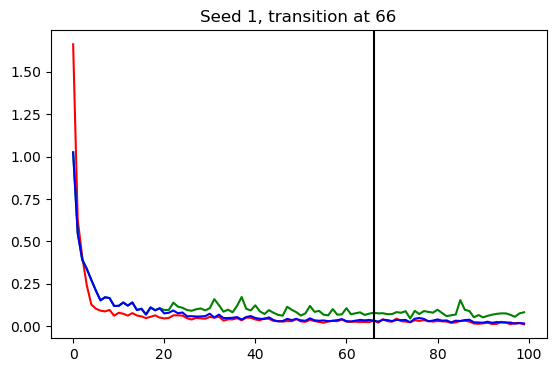

Seed 1


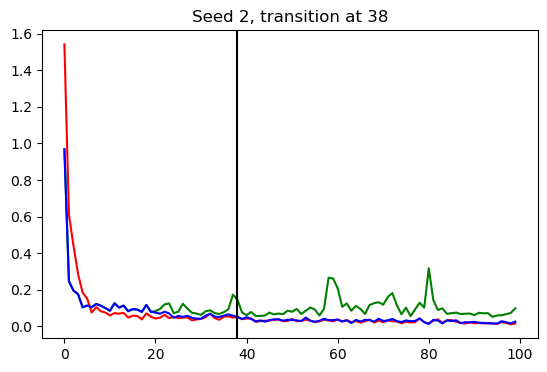

Seed 2


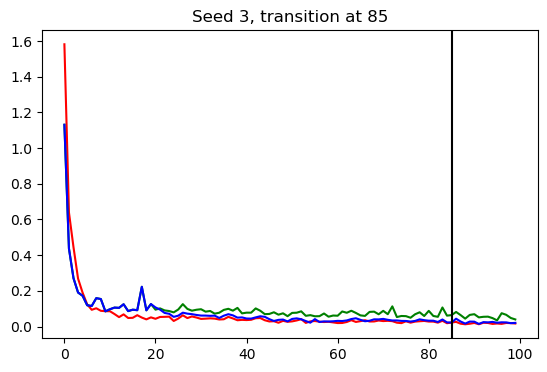

Seed 3


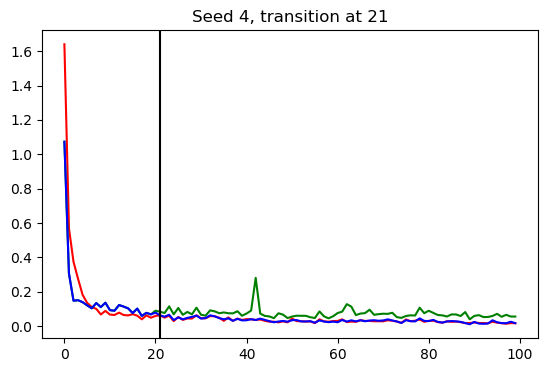

Seed 4


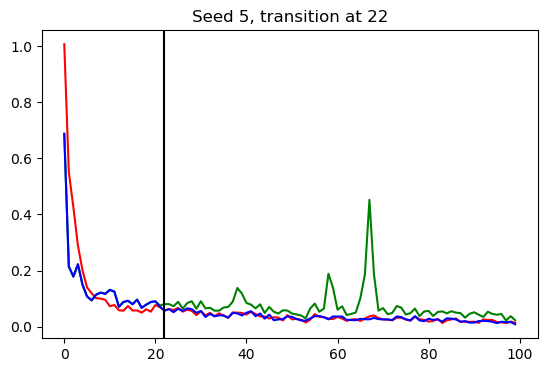

Seed 5


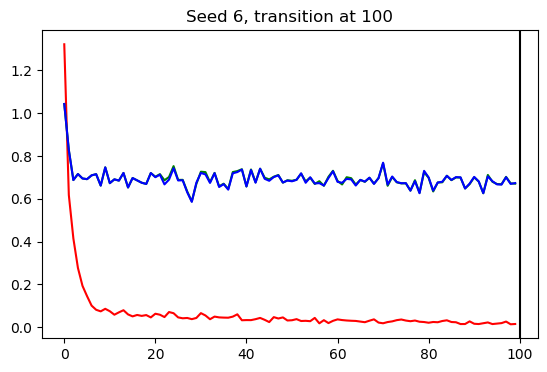

Seed 6


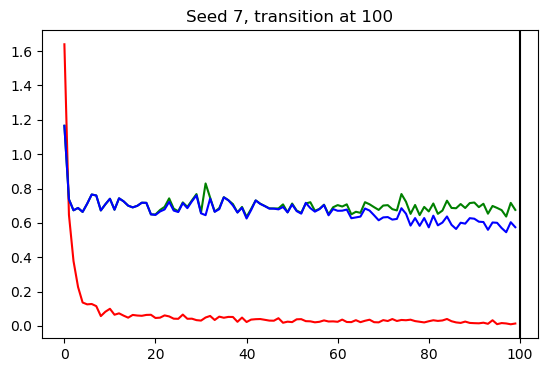

Seed 7


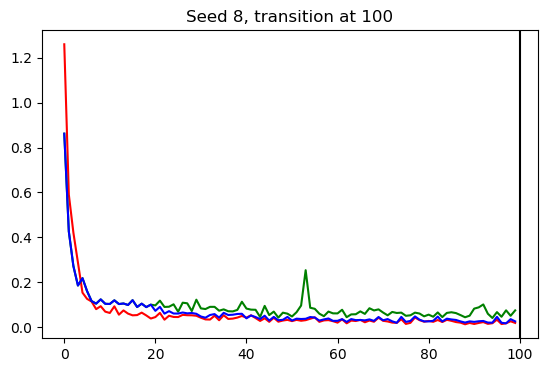

Seed 8


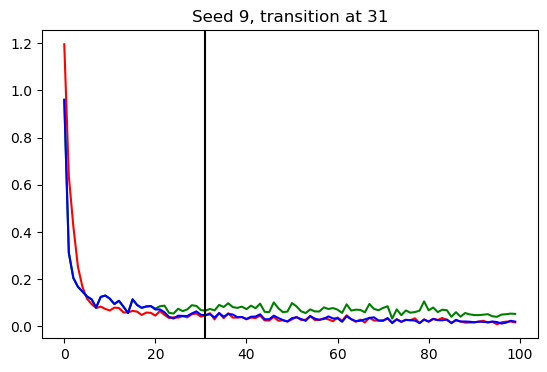

Seed 9


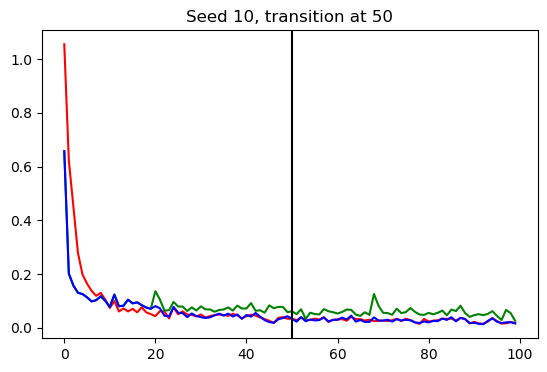

Seed 10


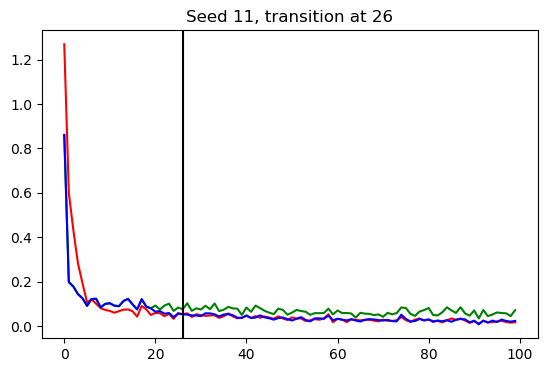

Seed 11


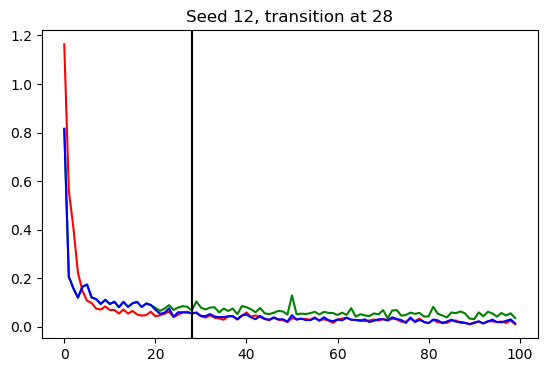

Seed 12


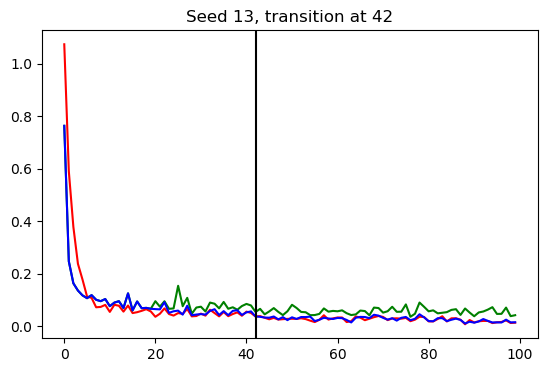

Seed 13


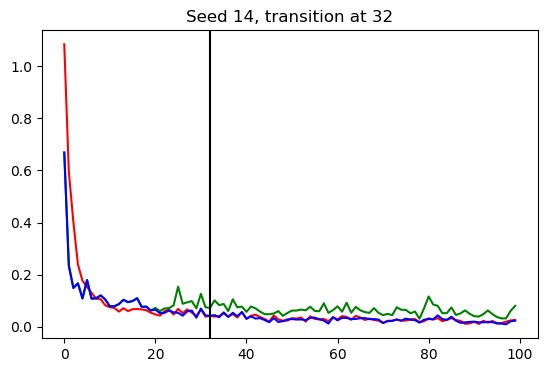

Seed 14


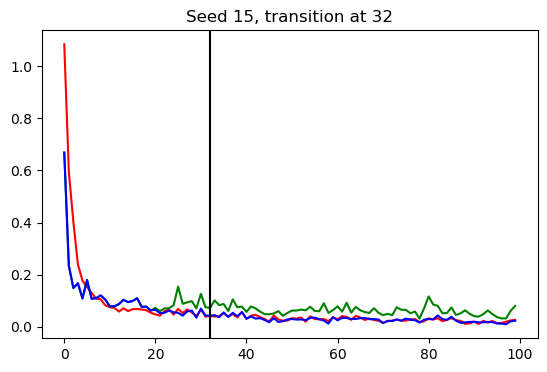

Seed 15


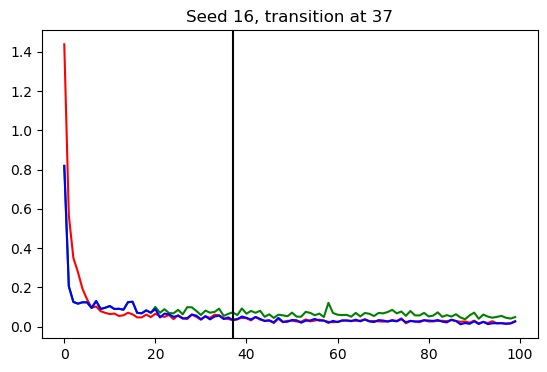

Seed 16


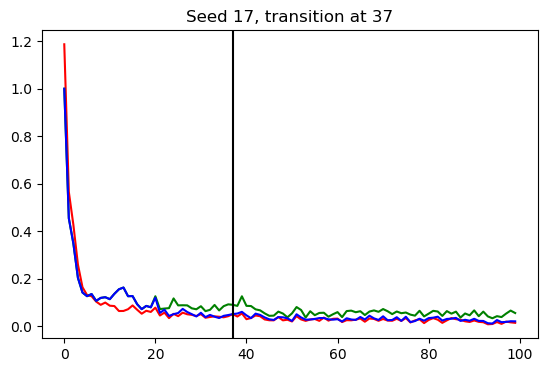

Seed 17


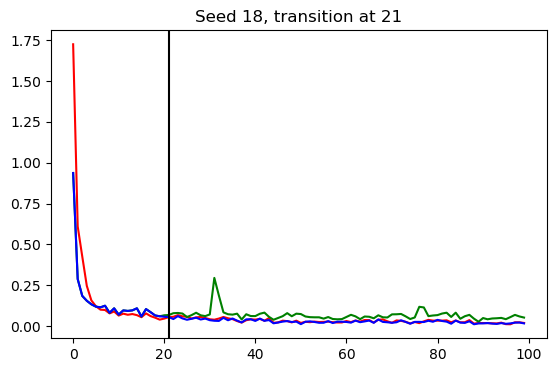

Seed 18


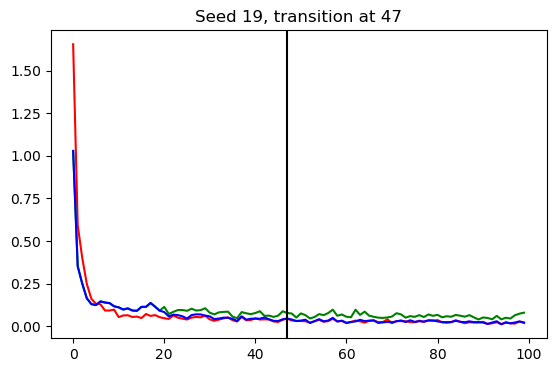

Seed 19


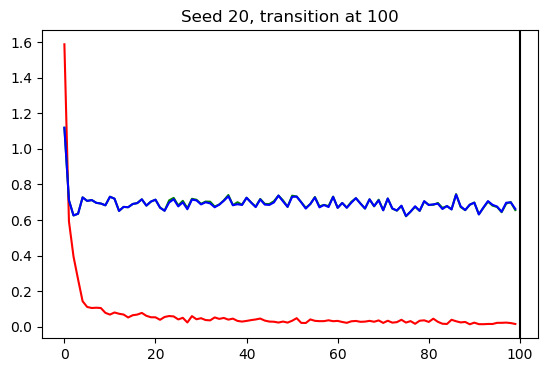

Seed 20


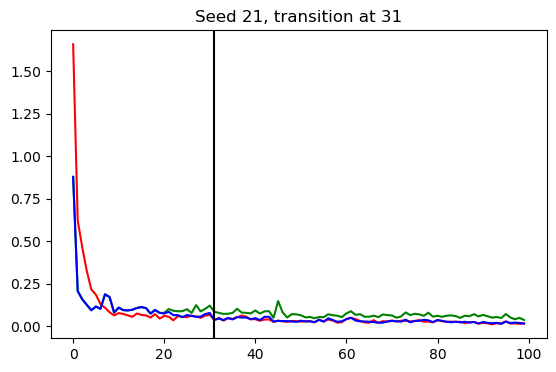

Seed 21


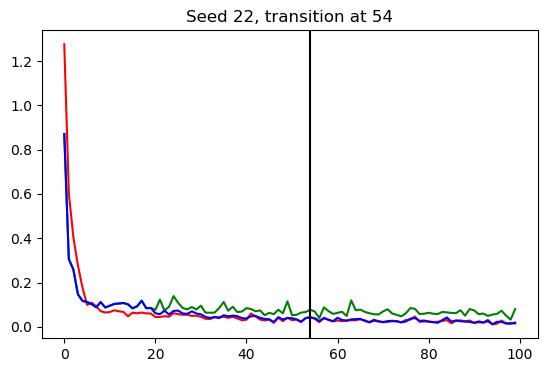

Seed 22


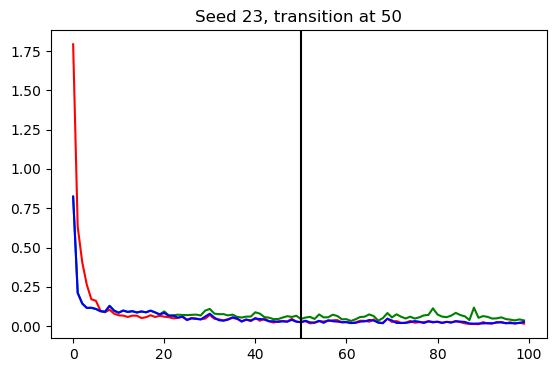

Seed 23


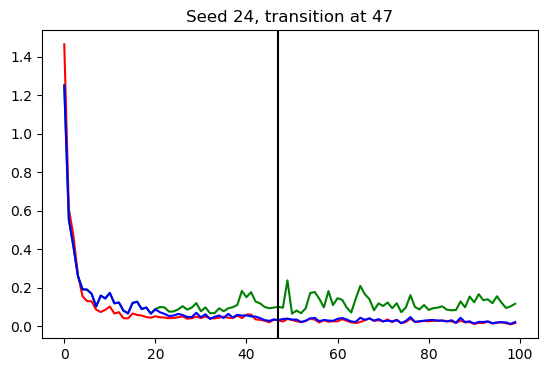

Seed 24


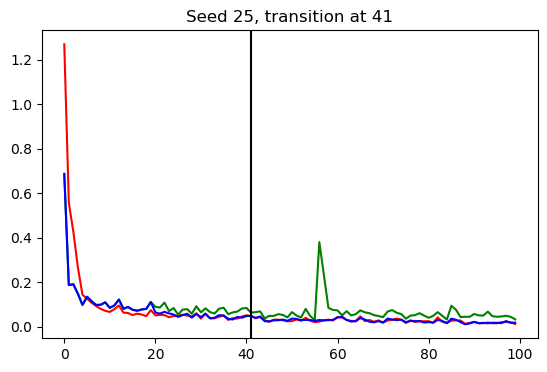

Seed 25


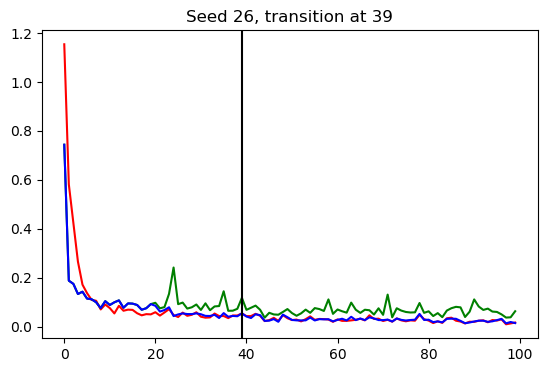

Seed 26


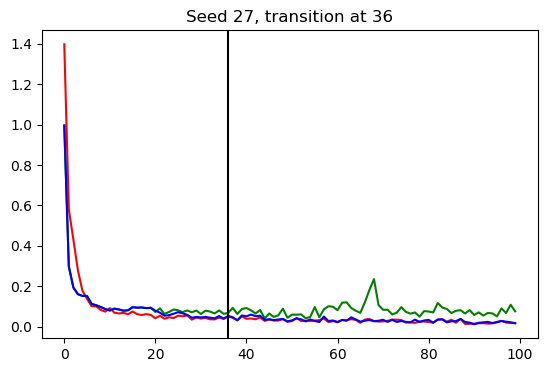

Seed 27


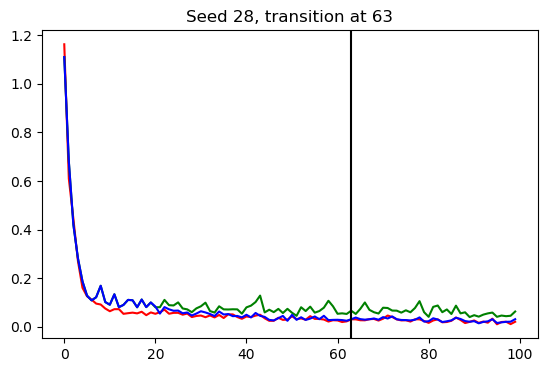

Seed 28


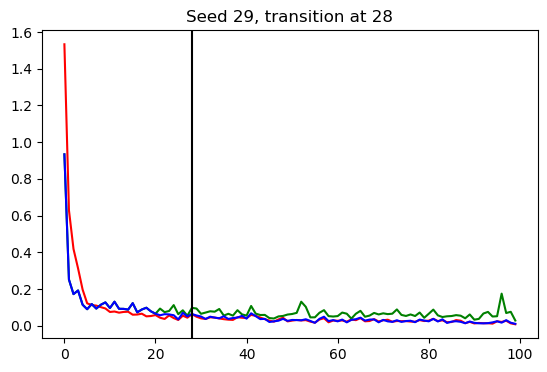

Seed 29


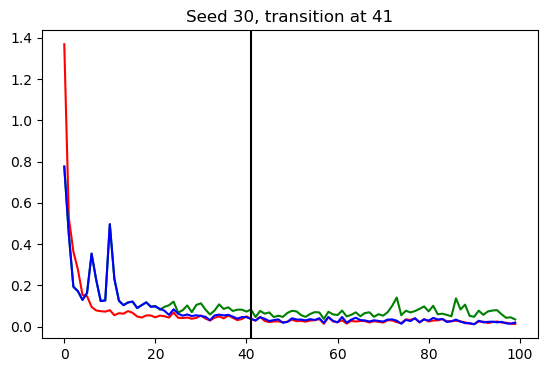

Seed 30


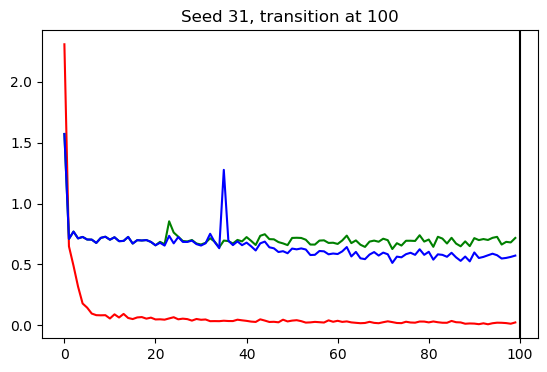

Seed 31


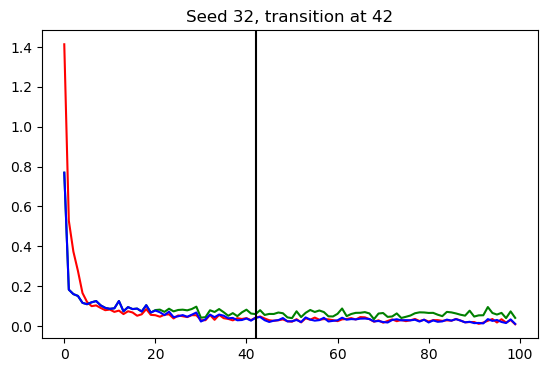

Seed 32


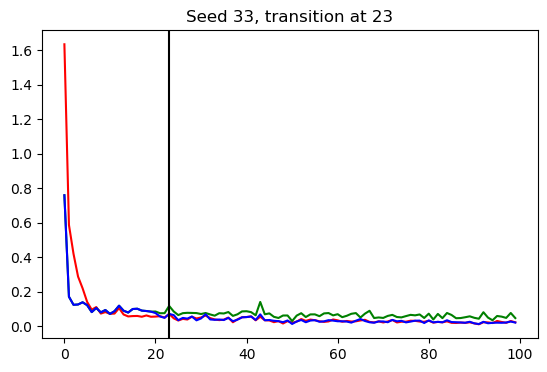

Seed 33


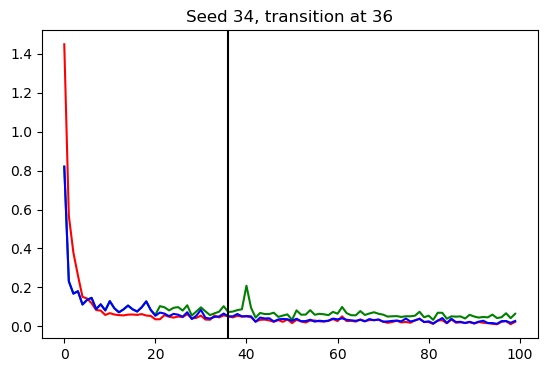

Seed 34


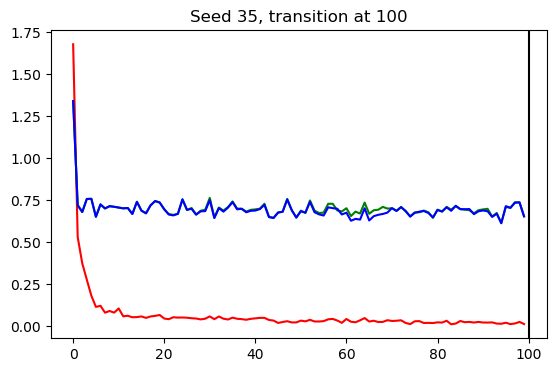

Seed 35


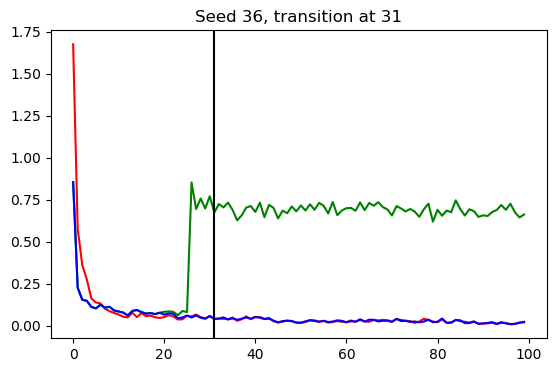

Seed 36


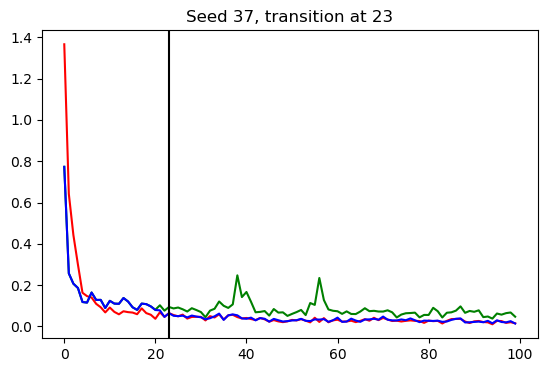

Seed 37


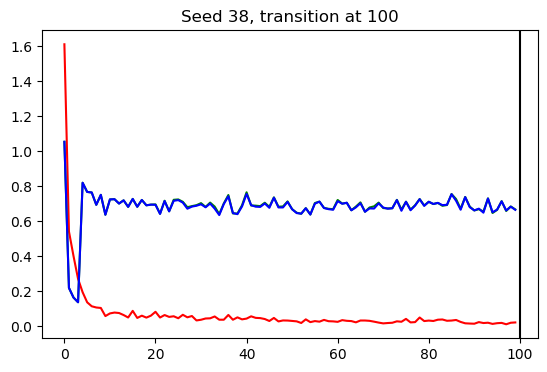

Seed 38


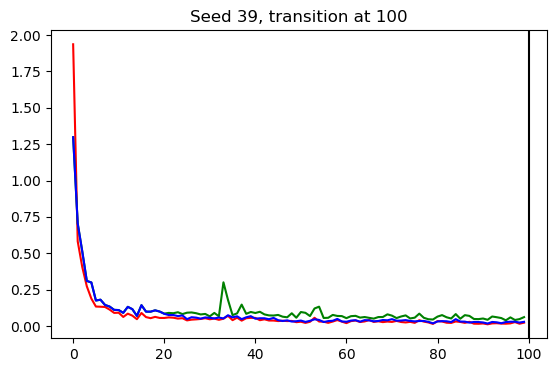

Seed 39


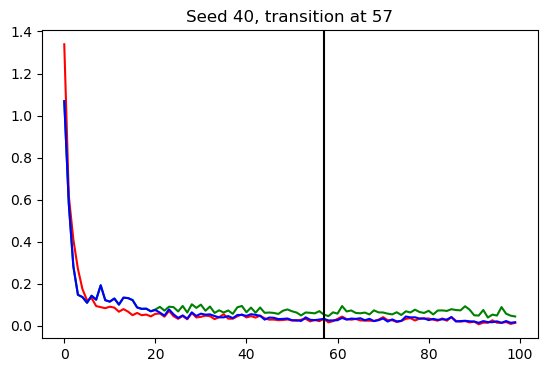

Seed 40


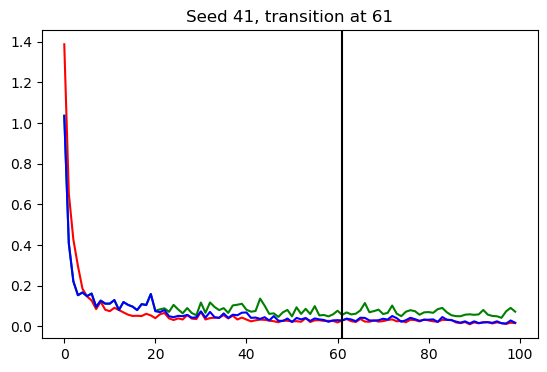

Seed 41


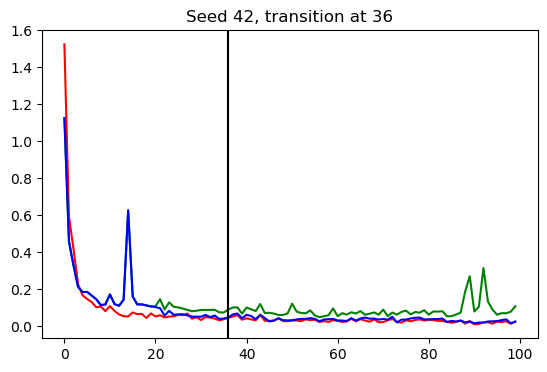

Seed 42


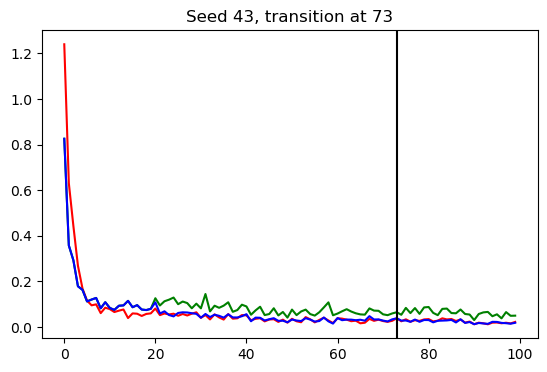

Seed 43


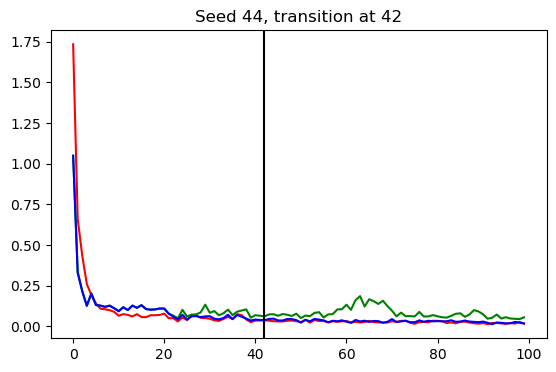

Seed 44


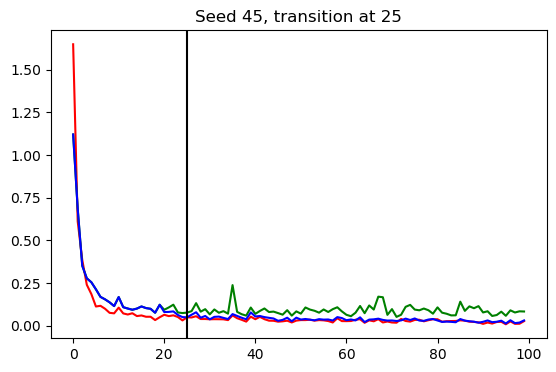

Seed 45


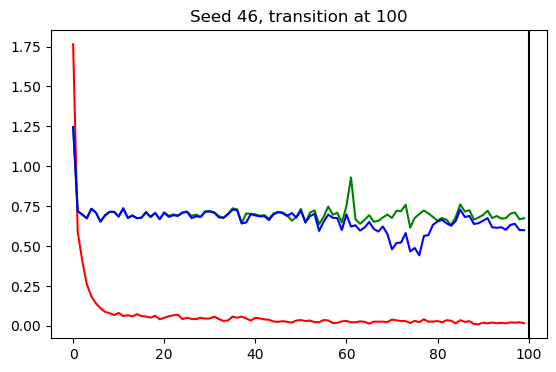

Seed 46


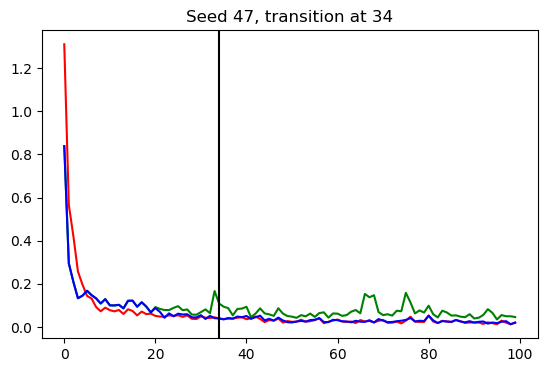

Seed 47


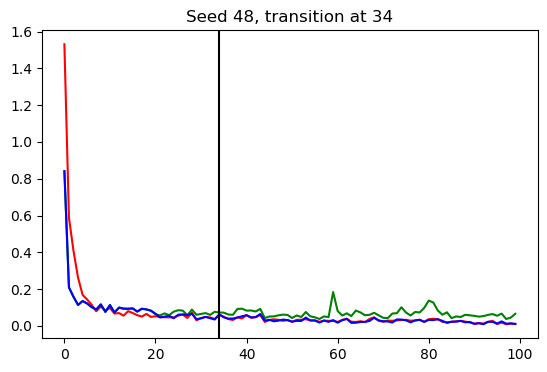

Seed 48


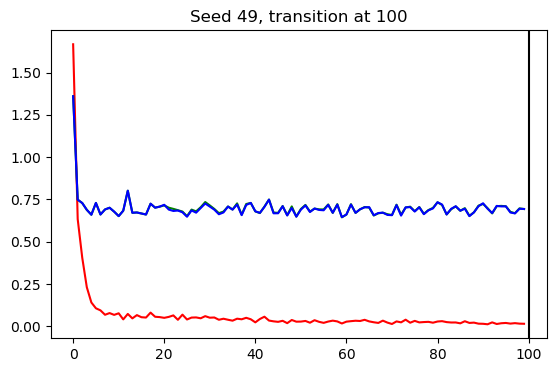

Seed 49


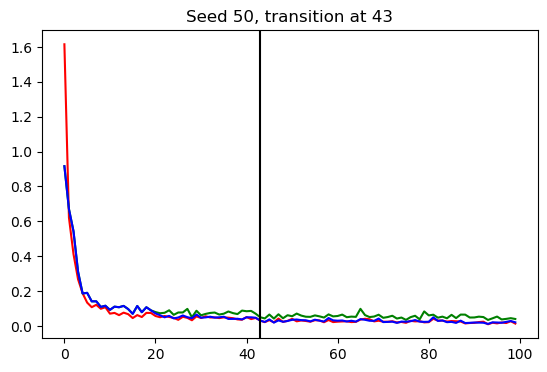

Seed 50


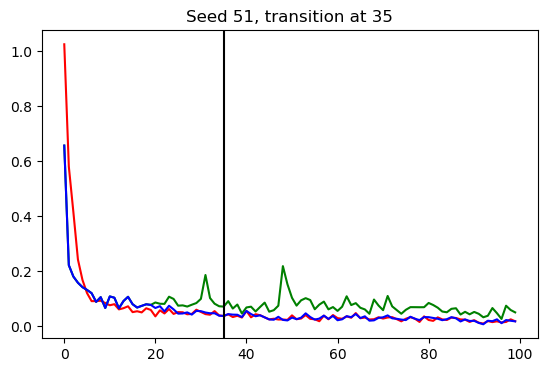

Seed 51


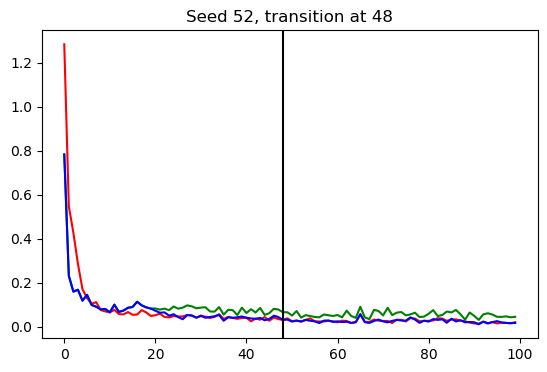

Seed 52


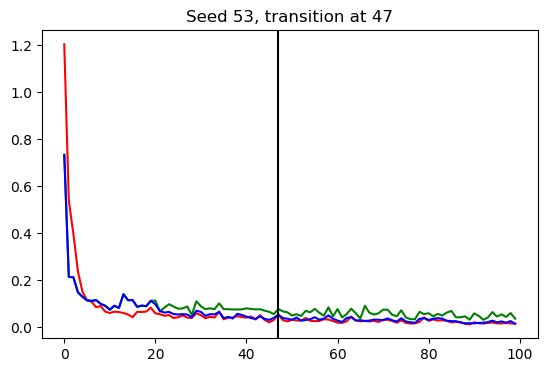

Seed 53


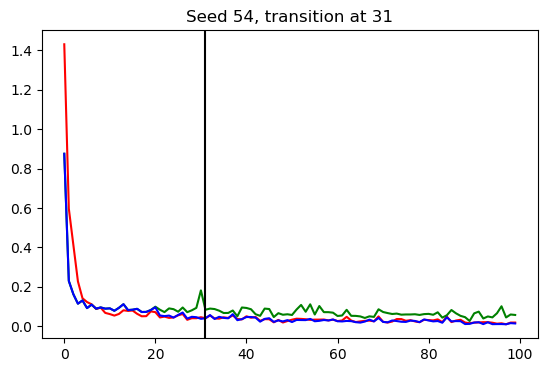

Seed 54


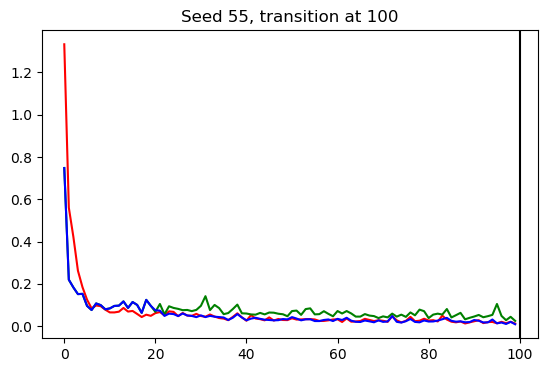

Seed 55


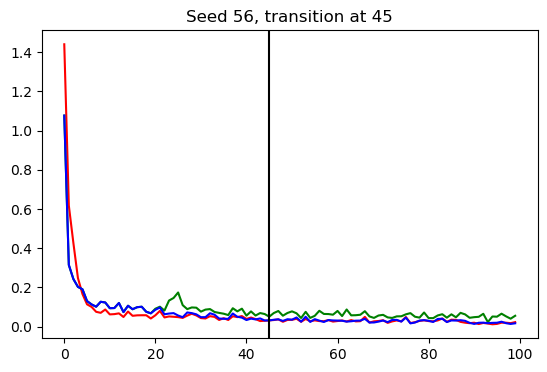

Seed 56


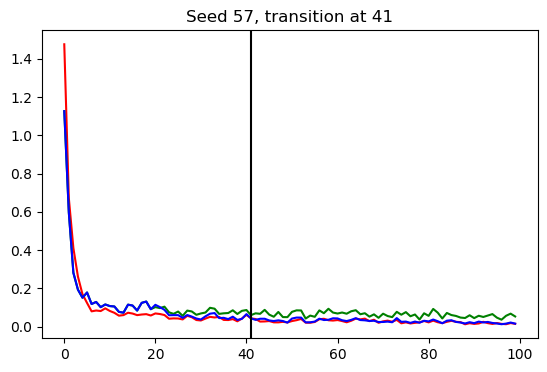

Seed 57


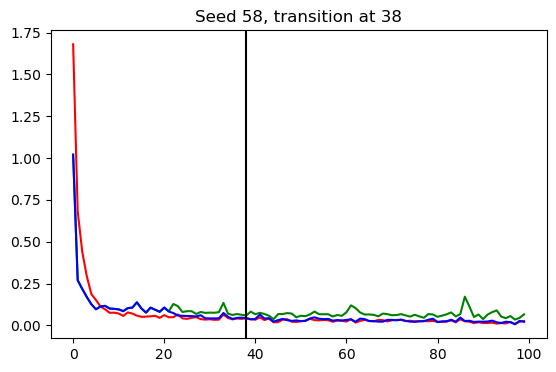

Seed 58


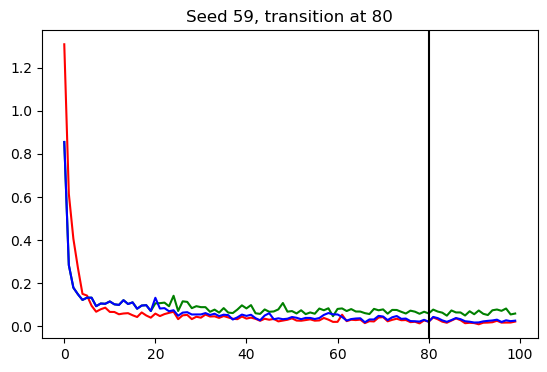

Seed 59


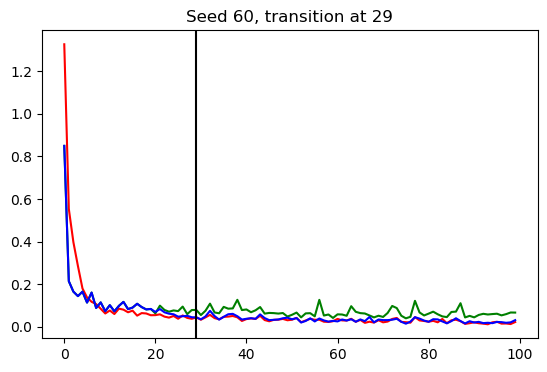

Seed 60


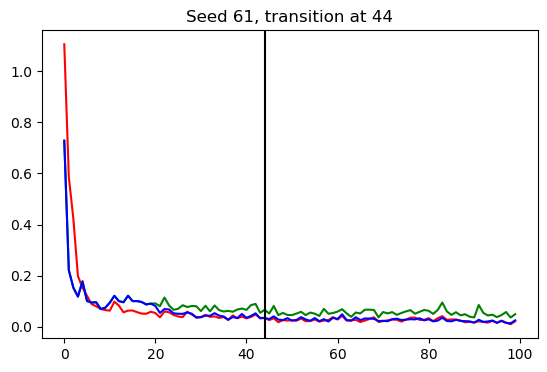

Seed 61


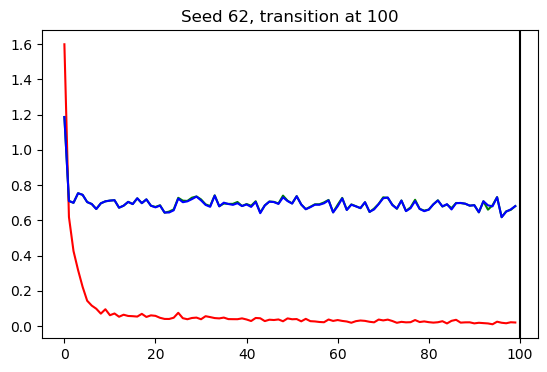

Seed 62


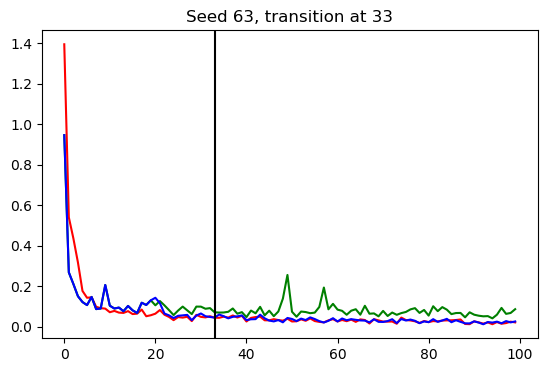

Seed 63


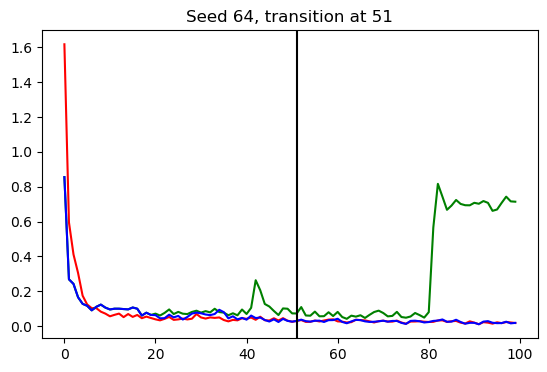

Seed 64


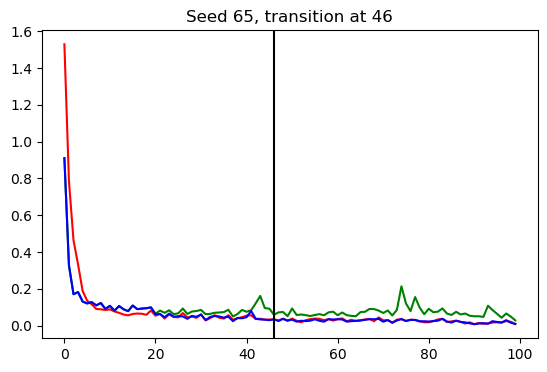

Seed 65


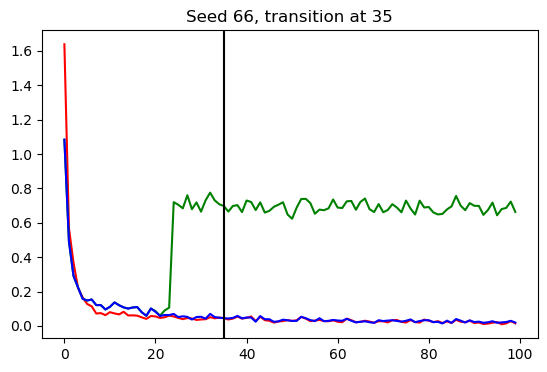

Seed 66


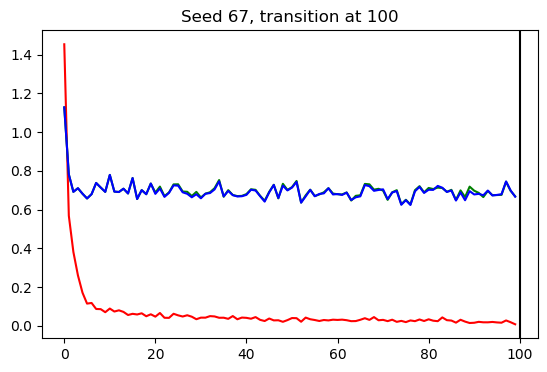

Seed 67


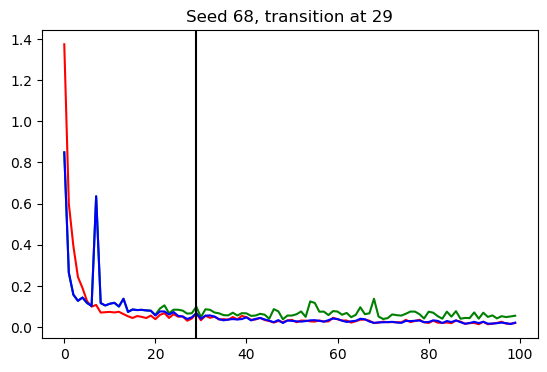

Seed 68


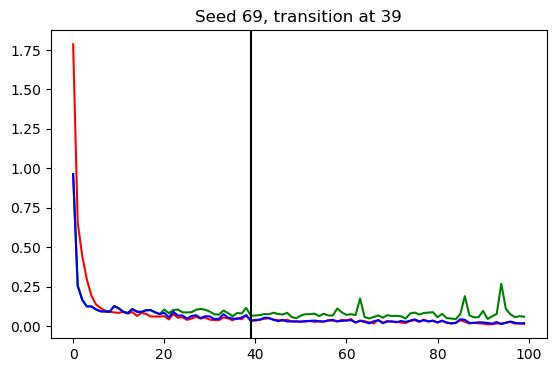

Seed 69


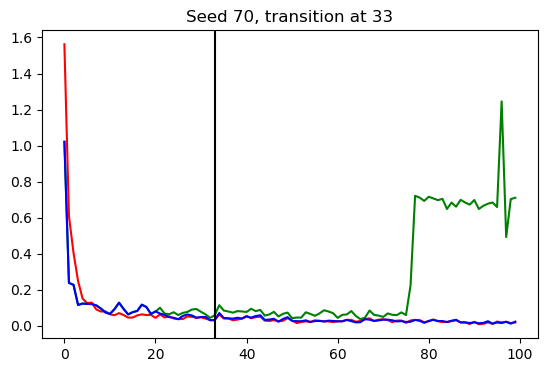

Seed 70


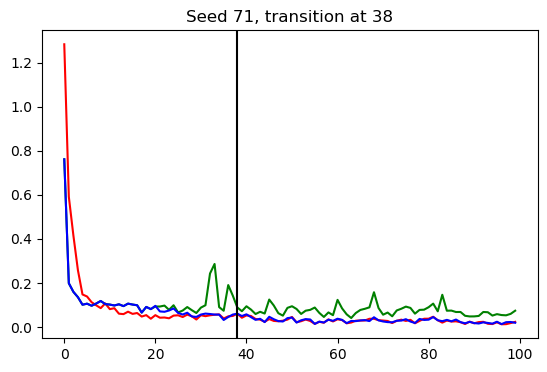

Seed 71


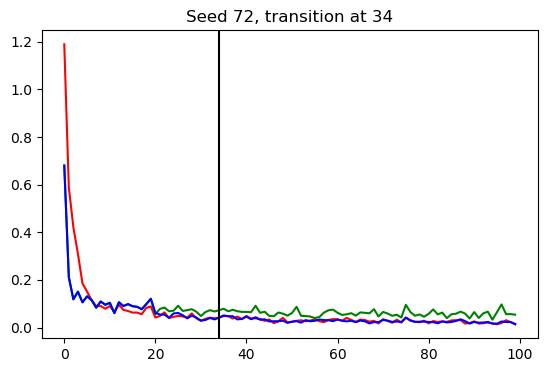

Seed 72


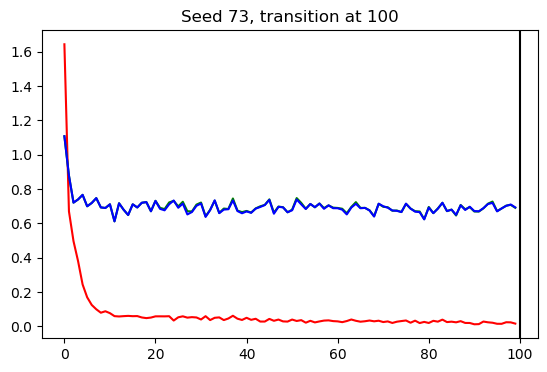

Seed 73


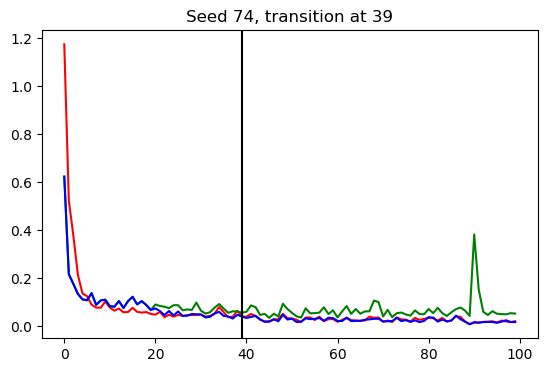

Seed 74


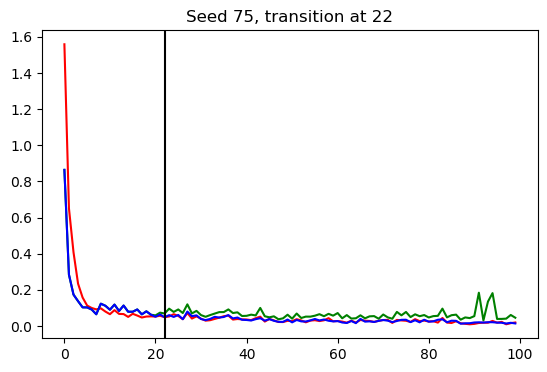

Seed 75


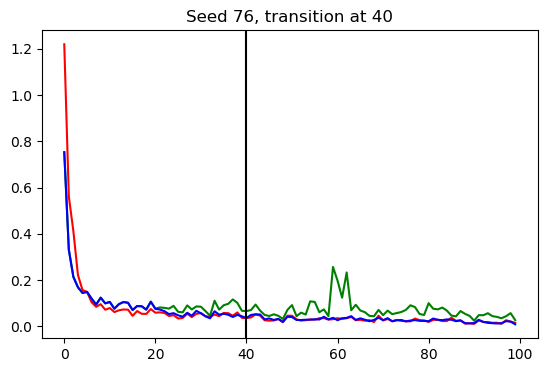

Seed 76


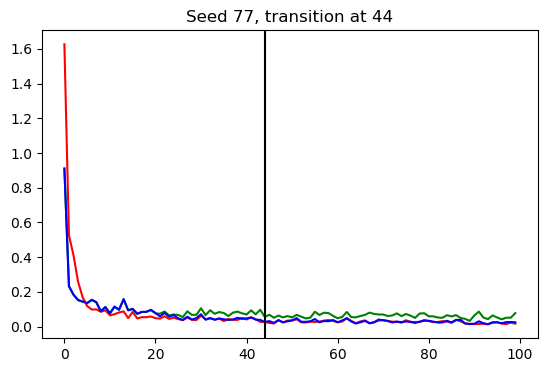

Seed 77


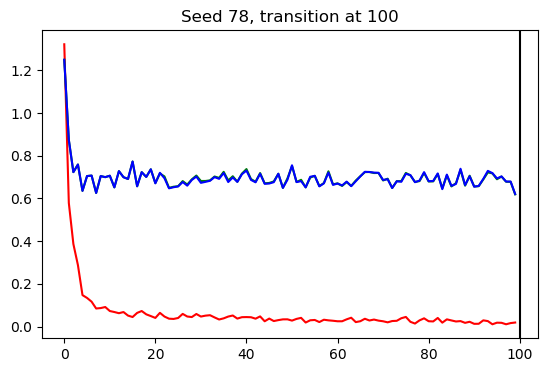

Seed 78


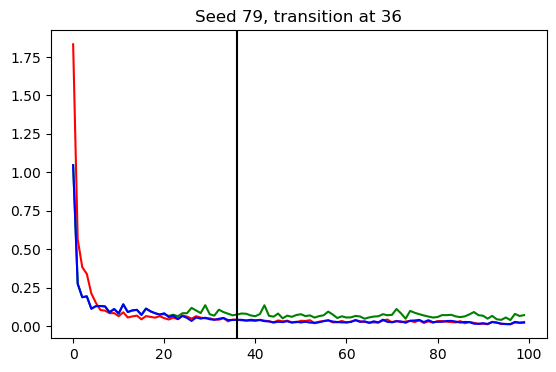

Seed 79


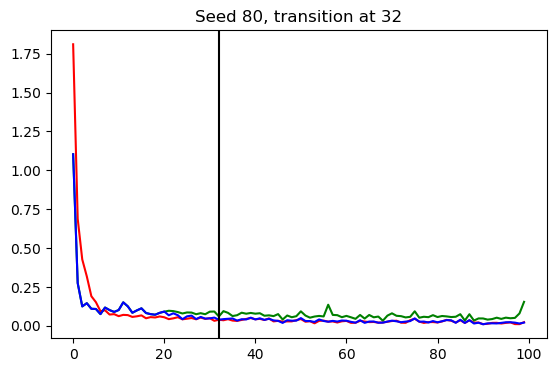

Seed 80


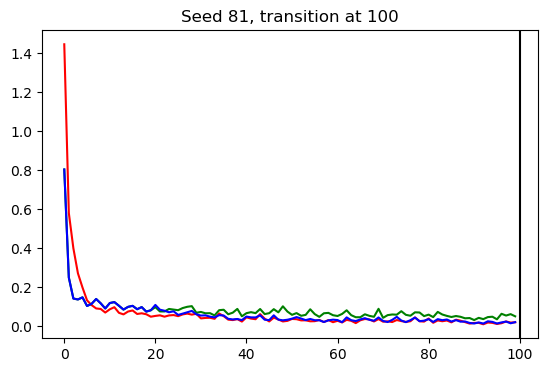

Seed 81


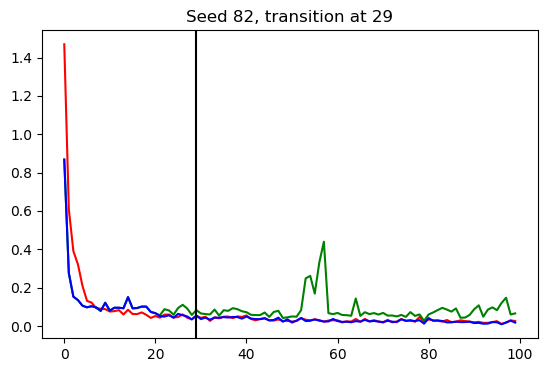

Seed 82


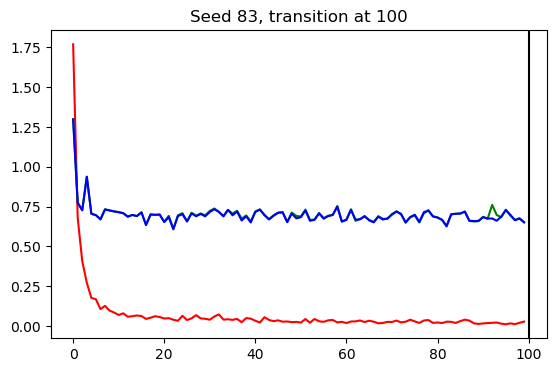

Seed 83


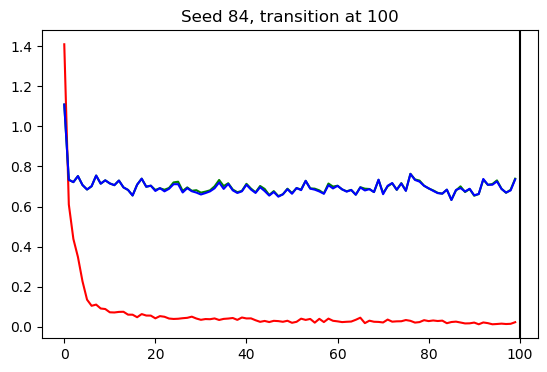

Seed 84


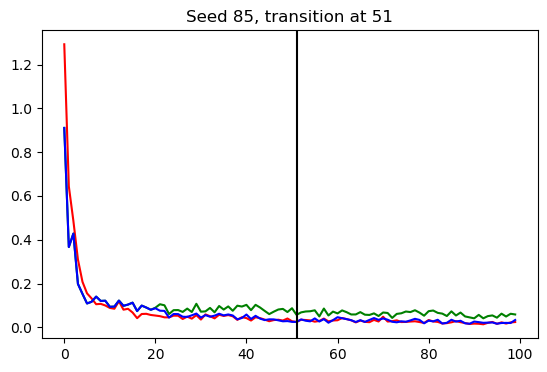

In [ ]:
import matplotlib.pyplot as plt
def plot_exps(c, exp1, exp2, exp3, tx):


    fig = plt.figure()
    fig.set_figheight(4)
    ax = fig.add_subplot(111)
    x1 = list(range(len(exp1)))
    line1, = ax.plot(x1, exp1, 'r', label='exp1',markersize=3)
    line1, = ax.plot(x1, exp2, 'g', label='exp2',markersize=3)
    line1, = ax.plot(x1, exp3, 'b', label='exp3',markersize=3)
    
    # tx= [float(abs(s1-s2)/s2)<0.01 for s1,s2 in list(zip(exp2,exp3))].index(True)
    plt.axvline(x = tx, color = 'k', label = 'axvline - full height')
    plt.title(f"Seed {c}, transition at {tx}")
    plt.show()

with open('ds_ner.write', 'r') as f:
    c=0
    transitions = []
    for line in f:
        
        
        # print(line.split(']'))
        if line!='d1,d2,d3\n':
            
            print(f"Seed {c}")
            c+=1
            exp1 = [float(s.strip()) for s in line.split(']')[0][1:].split(',')]
            exp2 = [float(s.strip()) for s in line.split(']')[1][2:].split(',')]
            exp3 = [float(s.strip()) for s in line.split(']')[2][2:].split(',')]
            
            try:
                tx= [float(abs(s1-s2)/s2)<0.01 for s1,s2 in list(zip(exp3[20:],exp1[20:]))].index(True)+20
            except:
                tx = 100
                
            transitions.append(tx)
            
            plot_exps(c,exp1, exp2, exp3, tx)
            
        
        

In [36]:
import numpy as np

In [38]:
transitions = transitions[:-1]
print("1000 step transition experiments")
print("---")
print(f"Count of successful transition - {len(transitions) - transitions.count(100)}")
print(f"Count of failed transition - {transitions.count(100)}")
print(f"% successful transition - { 100*(len(transitions) - transitions.count(100))/len(transitions) }")
print(f"% successful transition (<= step 250) - {100*([ t<=25 and t>20 for t in transitions].count(True) / len(transitions))}")      
print(f"% successful transition (<= step 500) - {100*([ t<=50 and t>20 for t in transitions].count(True) / len(transitions))}")      
print(f"% successful transition (<= step 750) - {100*([ t<=75 and t>20 for t in transitions].count(True) / len(transitions))}")  
print(f"Median transition step - {10*np.median(transitions)}")  
print(f"Min transition step - {10*np.min(transitions)}")  
print(f"Max transition step - {10*np.max(transitions)}")  

1000 step transition experiments
---
Count of successful transition - 80
Count of failed transition - 20
% successful transition - 80.0
% successful transition (<= step 250) - 7.000000000000001
% successful transition (<= step 500) - 67.0
% successful transition (<= step 750) - 77.0
Median transition step - 410.0
Min transition step - 210
Max transition step - 1000


In [106]:
!pwd

/root/transformers/examples/pytorch
